#FEATURES

##IMPORTS

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F

from torchvision import transforms, datasets
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import os
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from PIL import Image

import argparse

##CELDA 1: Configuración del Dataset, DataLoader y Modelo ResNet18 Preentrenado con Transformaciones de Imágenes y Optimización

In [ ]:
from google.colab import drive
from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import models, transforms

# Monta Google Drive
drive.mount('/content/drive')

# Define el tamaño del lote (batch size) y el número de épocas.
num_epochs = 50
batch_size = 8
n_clases = 2  # Número de clases a usar

# Redimensiona las imágenes para que todas tengan las mismas dimensiones.
desired_size = (3, 224, 224)  # Ejemplo de tamaño deseado
transform = transforms.Compose([
    transforms.Resize(desired_size[1:]),  # Redimensiona las imágenes
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 2) - 1)  # Normaliza los tensores al rango [-1, 1]
])

def comparator(x):
    return x[1]

# Define el directorio donde están las imágenes en Google Drive
data_dir = '/content/drive/My Drive/melanoma_cancer_dataset'

# Carga el conjunto de datos desde las carpetas de Google Drive aplicando las transformaciones
train_set = ImageFolder(root=f'{data_dir}/test', transform=transform)
test_set = ImageFolder(root=f'{data_dir}/train', transform=transform)

# Muestra las clases y sus índices
print("Classes:", train_set.classes)
print("Class to idx:", train_set.class_to_idx)

# Filtrar las imágenes con etiquetas menores al número de clases
filtered_train_set = [(img, label) for img, label in zip(train_set, train_set.targets) if label < n_clases]
filtered_test_set = [(img, label) for img, label in zip(test_set, test_set.targets) if label < n_clases]

# Crear un TensorDataset a partir del conjunto filtrado
train_x, train_y = zip(*filtered_train_set)
train_x = torch.stack([img for img, label in train_x])
train_y = torch.tensor(train_y)

test_x, test_y = zip(*filtered_test_set)
test_x = torch.stack([img for img, label in test_x])
test_y = torch.tensor(test_y)

# Crear DataLoader para el conjunto de entrenamiento
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Crear DataLoader para el conjunto de prueba
test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Forma de train_x:", train_x.shape)
print("Forma de train_y:", train_y.shape)
print("Forma de test_x:", test_x.shape)
print("Forma de test_y:", test_y.shape)

# Carga un modelo ResNet18 preentrenado y ajusta la última capa para 2 clases.
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, n_clases)

# Establece el dispositivo de cálculo y configura el optimizador y la función de pérdida.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001, betas=(0.5, 0.999))


Mounted at /content/drive
Classes: ['benign', 'malignant']
Class to idx: {'benign': 0, 'malignant': 1}
Forma de train_x: torch.Size([1000, 3, 224, 224])
Forma de train_y: torch.Size([1000])
Forma de test_x: torch.Size([9605, 3, 224, 224])
Forma de test_y: torch.Size([9605])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


## CELDA 1 INFO

In [ ]:
# Imprimir información relevante del conjunto de datos y del modelo

# Tamaño del conjunto de entrenamiento y prueba (antes de filtrar)
print("\n===== TAMAÑO DEL CONJUNTO DE ENTRENAMIENTO Y PRUEBA =====")
print(f"Tamaño del conjunto de entrenamiento original: {len(train_set)}")
print(f"Tamaño del conjunto de prueba original: {len(test_set)}")

# Información del conjunto de entrenamiento filtrado
print("\n===== INFORMACIÓN SOBRE EL CONJUNTO FILTRADO DE ENTRENAMIENTO =====")
print(f"Tamaño del conjunto filtrado de entrenamiento: {len(filtered_train_set)} imágenes")

# Forma de las imágenes y etiquetas del conjunto de entrenamiento
print("\n===== INFORMACIÓN SOBRE EL CONJUNTO DE ENTRENAMIENTO =====")
print(f"Forma de train_x (imágenes de entrenamiento): {train_x.shape}")
print(f"Forma de train_y (etiquetas de entrenamiento): {train_y.shape}")
print(f"Valor mínimo de train_x: {train_x.min().item()}")
print(f"Valor máximo de train_x: {train_x.max().item()}")
print(f"Promedio de train_x: {train_x.mean().item()}")
print(f"Cantidad de elementos en train_x: {train_x.numel()}")

# Información del conjunto de prueba filtrado
print("\n===== INFORMACIÓN SOBRE EL CONJUNTO FILTRADO DE PRUEBA =====")
print(f"Tamaño del conjunto filtrado de prueba: {len(filtered_test_set)} imágenes")

# Forma de las imágenes y etiquetas del conjunto de prueba
print("\n===== INFORMACIÓN SOBRE EL CONJUNTO DE PRUEBA =====")
print(f"Forma de test_x (imágenes de prueba): {test_x.shape}")
print(f"Forma de test_y (etiquetas de prueba): {test_y.shape}")
print(f"Valor mínimo de test_x: {test_x.min().item()}")
print(f"Valor máximo de test_x: {test_x.max().item()}")
print(f"Promedio de test_x: {test_x.mean().item()}")
print(f"Cantidad de elementos en test_x: {test_x.numel()}")

# Información sobre el modelo ResNet18
print("\n===== INFORMACIÓN SOBRE EL MODELO RESNET18 =====")
print(f"Dispositivo utilizado: {device}")
##print(f"Estructura del modelo ResNet18:\n{resnet18}")  # Muestra la arquitectura del modelo
print(f"Número de capas del modelo: {len(list(resnet18.children()))}")  # Cantidad de capas del modelo

# Optimización y función de pérdida
print("\n===== OPTIMIZADOR Y FUNCIÓN DE PÉRDIDA =====")
print(f"Función de pérdida: {criterion}")
print(f"Optimizador utilizado: {optimizer.__class__.__name__}")  # Tipo de optimizador
##print(f"Parámetros del optimizador:\n{optimizer.state_dict()}")  # Estado actual del optimizador

# Parámetros del entrenamiento
print("\n===== PARÁMETROS DEL ENTRENAMIENTO =====")
print(f"Número de épocas: {num_epochs}")
print(f"Tamaño del lote (batch size): {batch_size}")
print(f"Número de clases: {n_clases}")

# Parámetros del modelo
print("\n===== PARÁMETROS DEL MODELO =====")
total_params = sum(p.numel() for p in resnet18.parameters())
trainable_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
print(f"Total de parámetros en ResNet18: {total_params}")
print(f"Total de parámetros entrenables: {trainable_params}")

# Distribución de clases en el conjunto de entrenamiento
from collections import Counter
train_class_counts = Counter(train_y.tolist())

print("\n===== DISTRIBUCIÓN DE CLASES EN EL CONJUNTO DE ENTRENAMIENTO =====")
for class_label, count in train_class_counts.items():
    print(f"Clase {class_label}: {count} imágenes")

# Distribución de clases en el conjunto de prueba
test_class_counts = Counter(test_y.tolist())

print("\n===== DISTRIBUCIÓN DE CLASES EN EL CONJUNTO DE PRUEBA =====")
for class_label, count in test_class_counts.items():
    print(f"Clase {class_label}: {count} imágenes")

# Estado del optimizador
print("\n===== ESTADO DEL OPTIMIZADOR =====")
for param_group in optimizer.param_groups:
    print(f"Tasa de aprendizaje: {param_group['lr']}")
    print(f"Betas: {param_group['betas']}")


===== TAMAÑO DEL CONJUNTO DE ENTRENAMIENTO Y PRUEBA =====
Tamaño del conjunto de entrenamiento original: 1000
Tamaño del conjunto de prueba original: 9605

===== INFORMACIÓN SOBRE EL CONJUNTO FILTRADO DE ENTRENAMIENTO =====
Tamaño del conjunto filtrado de entrenamiento: 1000 imágenes

===== INFORMACIÓN SOBRE EL CONJUNTO DE ENTRENAMIENTO =====
Forma de train_x (imágenes de entrenamiento): torch.Size([1000, 3, 224, 224])
Forma de train_y (etiquetas de entrenamiento): torch.Size([1000])
Valor mínimo de train_x: -1.0
Valor máximo de train_x: 1.0
Promedio de train_x: 0.1866760402917862
Cantidad de elementos en train_x: 150528000

===== INFORMACIÓN SOBRE EL CONJUNTO FILTRADO DE PRUEBA =====
Tamaño del conjunto filtrado de prueba: 9605 imágenes

===== INFORMACIÓN SOBRE EL CONJUNTO DE PRUEBA =====
Forma de test_x (imágenes de prueba): torch.Size([9605, 3, 224, 224])
Forma de test_y (etiquetas de prueba): torch.Size([9605])
Valor mínimo de test_x: -1.0
Valor máximo de test_x: 1.0
Promedio de t


===== ASIGNACIÓN DE CLASES =====
Clase 0: benign
Clase 1: malignant


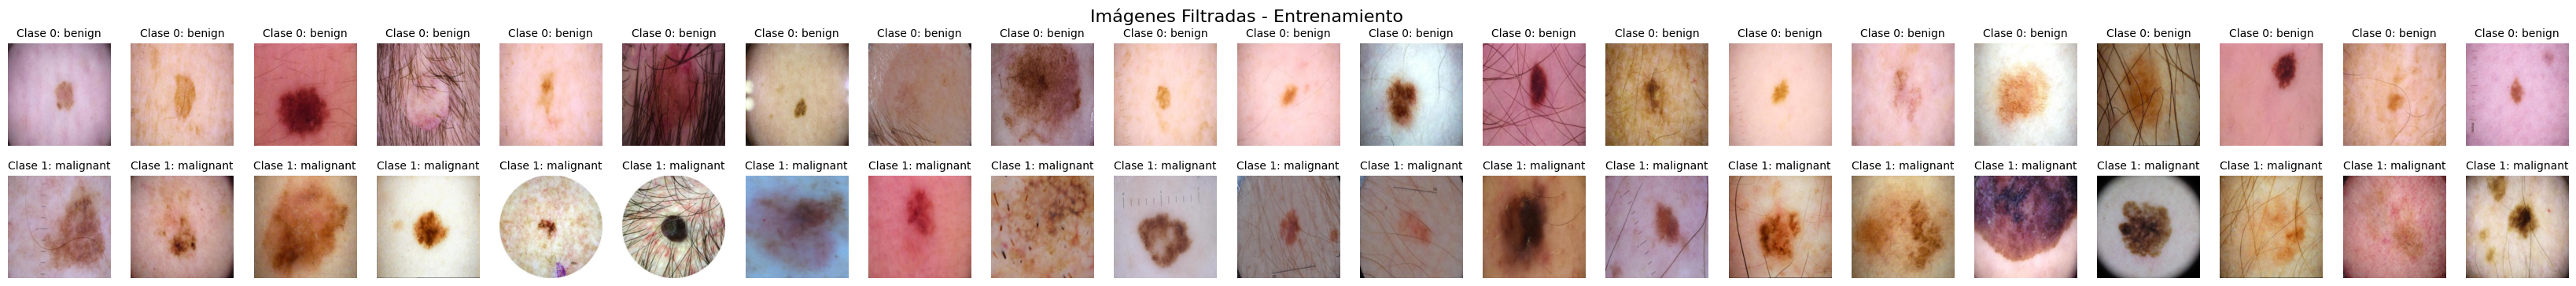

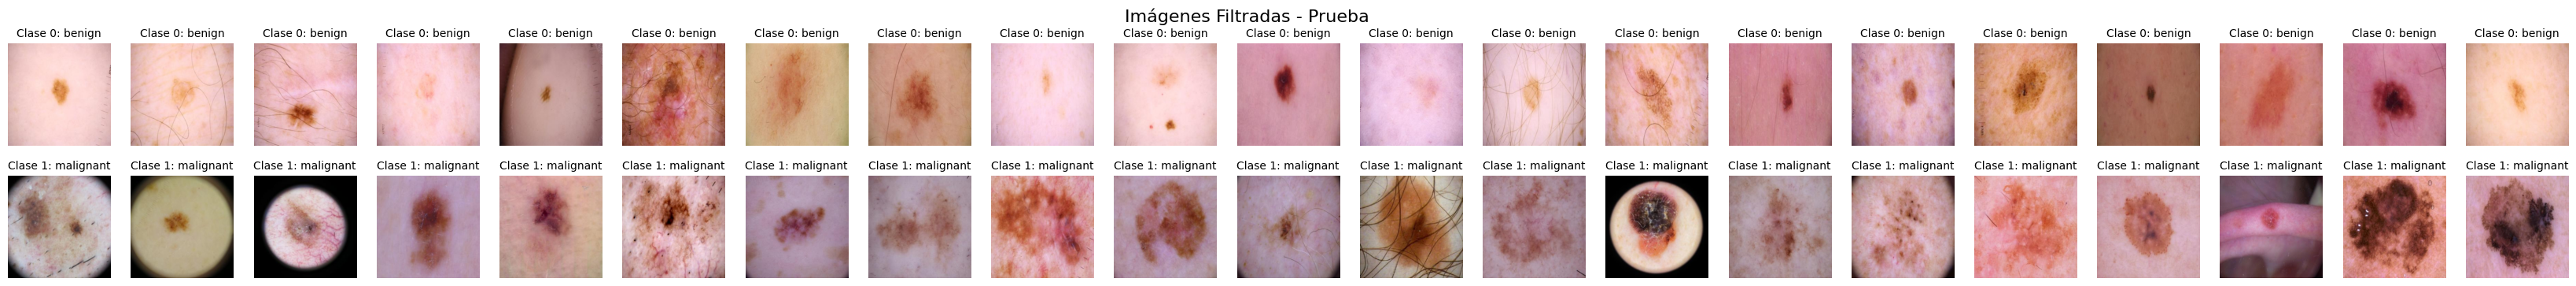

In [ ]:
import matplotlib.pyplot as plt

# Obtener nombres de clases desde ImageFolder
class_names = train_set.classes  # ['Cancer', 'Non-Cancer']
class_mapping = {idx: name for name, idx in train_set.class_to_idx.items()}

# Imprimir la correspondencia de clases
print("\n===== ASIGNACIÓN DE CLASES =====")
for class_idx, class_name in class_mapping.items():
    print(f"Clase {class_idx}: {class_name}")

# Función para mostrar imágenes por clase con títulos correctos
def mostrar_imagenes_por_clase(tensor_images, tensor_labels, num_clases, num_imagenes=21, titulo="Imágenes por Clase"):
    fig, axs = plt.subplots(num_clases, num_imagenes, figsize=(num_imagenes*2, num_clases*2))
    fig.suptitle(titulo, fontsize=16)

    for clase in range(num_clases):
        idx_clase = (tensor_labels == clase).nonzero(as_tuple=True)[0][:num_imagenes]  # Obtener índices de imágenes de la clase actual

        for i, idx in enumerate(idx_clase):
            ax = axs[clase, i]
            img = tensor_images[idx]
            img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Desnormalizar de [-1, 1] a [0, 1]
            ax.imshow(img)
            ax.set_title(f"Clase {clase}: {class_mapping[clase]}", fontsize=10)
            ax.axis('off')

        # Si no hay imágenes suficientes para una clase, ocultar los ejes restantes
        for i in range(len(idx_clase), num_imagenes):
            axs[clase, i].axis('off')

    plt.show()

# Mostrar imágenes filtradas del conjunto de entrenamiento por clase
mostrar_imagenes_por_clase(train_x, train_y, n_clases, titulo="Imágenes Filtradas - Entrenamiento")

# Mostrar imágenes filtradas del conjunto de prueba por clase
mostrar_imagenes_por_clase(test_x, test_y, n_clases, titulo="Imágenes Filtradas - Prueba")


##CELDA 2: Entrenamiento del Modelo ResNet18 y Guardado del Extractor de Características

In [ ]:
import pandas as pd

# Entrenamiento del modelo con registro de pérdida
losses_per_epoch = []  # Lista para almacenar las pérdidas por época

resnet18.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        predictions = resnet18(batch_x)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)  # Pérdida promedio por época
    losses_per_epoch.append(avg_loss)  # Guardar la pérdida de la época
    print(f"Epoch: {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

# Guarda el modelo entrenado
torch.save({'F': resnet18.state_dict()}, 'FeatureExtractor.pth')

# Guardar las pérdidas por época en un archivo de Excel
losses_df = pd.DataFrame({'Epoch': range(1, num_epochs + 1), 'Loss': losses_per_epoch})
excel_filename = 'training_losses.xlsx'
losses_df.to_excel(excel_filename, index=False)

print(f"Las pérdidas por época se han guardado en {excel_filename}")


Epoch: 1/50, Average Loss: 0.5767
Epoch: 2/50, Average Loss: 0.3717
Epoch: 3/50, Average Loss: 0.3680
Epoch: 4/50, Average Loss: 0.3345
Epoch: 5/50, Average Loss: 0.2838
Epoch: 6/50, Average Loss: 0.3256
Epoch: 7/50, Average Loss: 0.3456
Epoch: 8/50, Average Loss: 0.2931
Epoch: 9/50, Average Loss: 0.2714
Epoch: 10/50, Average Loss: 0.3050
Epoch: 11/50, Average Loss: 0.2664
Epoch: 12/50, Average Loss: 0.2373
Epoch: 13/50, Average Loss: 0.2821
Epoch: 14/50, Average Loss: 0.2192
Epoch: 15/50, Average Loss: 0.2395
Epoch: 16/50, Average Loss: 0.2364
Epoch: 17/50, Average Loss: 0.2064
Epoch: 18/50, Average Loss: 0.1908
Epoch: 19/50, Average Loss: 0.2142
Epoch: 20/50, Average Loss: 0.1815
Epoch: 21/50, Average Loss: 0.1571
Epoch: 22/50, Average Loss: 0.1205
Epoch: 23/50, Average Loss: 0.1554
Epoch: 24/50, Average Loss: 0.0857
Epoch: 25/50, Average Loss: 0.1149
Epoch: 26/50, Average Loss: 0.0876
Epoch: 27/50, Average Loss: 0.0820
Epoch: 28/50, Average Loss: 0.0992
Epoch: 29/50, Average Loss: 0

##CELDA 3: Carga, Ajuste y Uso de un Modelo ResNet18 Preentrenado como Extractor de Características para Procesar Conjuntos de Datos de Entrenamiento y Prueba

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.models as models

# Carga un modelo preentrenado desde un archivo guardado, y prepara el modelo
# eliminando la capa de clasificación y fijando todos los parámetros para que no se actualicen durante el entrenamiento.
path = "FeatureExtractor.pth"
checkpoint = torch.load(path)  # No usamos weights_only, ya que este modo solo soporta modelos de torch.hub

# Inicializamos el modelo ResNet18
resnet18 = models.resnet18(pretrained=False)

# Ajustamos la capa final para que coincida con el modelo guardado (2 clases)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2)  # Cambiamos la capa final para que tenga 2 salidas

# Cargamos los pesos guardados en el modelo completo
resnet18.load_state_dict(checkpoint['F'])

# Eliminamos la última capa del modelo (el clasificador)
modules = list(resnet18.children())[:-1]  # Quitamos la capa de clasificación final
resnet18 = nn.Sequential(*modules)

# Fijamos los parámetros para evitar su actualización durante el uso del modelo como extractor de características
for p in resnet18.parameters():
    p.requires_grad = False

# Define una función para generar características usando ResNet18
def generate_features(resnet18, data_loader):
    resnet18 = resnet18.to(device)
    resnet18.eval()
    features = []
    labels = []
    with torch.no_grad():
        for i, (batch_x, batch_y) in enumerate(data_loader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            f = resnet18(batch_x).to('cpu')
            for x in f:
                features.append(x.view(-1).numpy())  # Aplanar las características
            labels.extend(batch_y.to('cpu').numpy())  # Convertimos a numpy directamente y extendemos la lista
    features = np.array(features)  # Convertimos la lista a un array numpy para mayor eficiencia
    features = torch.FloatTensor(features)  # Luego convertimos el array numpy a un tensor
    labels = torch.FloatTensor(labels)  # Convertimos las etiquetas a tensor de tipo FloatTensor
    feature_dataset = TensorDataset(features, labels)
    return feature_dataset

# Función para convertir el conjunto de datos de características en un mapa indexado por etiquetas
def convertDatasetToMap(feature_dataset):
    feature_dataset_list = sorted(feature_dataset, key=comparator)
    feature_dataset_map = []
    prev = 0
    ls = []
    for x in feature_dataset_list:
        if x[1] != prev:
            feature_dataset_map.append(ls)
            ls = []
        ls.append(x)
        prev = x[1]
    feature_dataset_map.append(ls)
    return feature_dataset_map

# Uso de las funciones para procesar conjuntos de entrenamiento y prueba
train_features_dataset = generate_features(resnet18, train_loader)
train_features_map = convertDatasetToMap(train_features_dataset)

test_features_dataset = generate_features(resnet18, test_loader)
test_features_map = convertDatasetToMap(test_features_dataset)

# Verificar el tamaño de las características extraídas
print("Tamaño de una característica extraída (train):", train_features_dataset.tensors[0][0].shape)
print("Tamaño de una característica extraída (test):", test_features_dataset.tensors[0][0].shape)

<ipython-input-8-7cc806cad7cb>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)  # No usamos weights_only, ya que este modo solo soporta modelo

Tamaño de una característica extraída (train): torch.Size([512])
Tamaño de una característica extraída (test): torch.Size([512])


##CELDA 3 INFO

In [ ]:
import torch
import numpy as np
from collections import Counter

# Cargar el modelo preentrenado desde un archivo guardado
print("\n===== CARGA DEL MODELO PREENTRENADO =====")
print(f"Modelo cargado desde: {path}")
print(f"Claves del checkpoint: {list(checkpoint.keys())}")

# Información sobre el modelo ajustado
print("\n===== INFORMACIÓN SOBRE EL MODELO AJUSTADO =====")
print(f"Número de capas antes de eliminar la última: {len(list(resnet18.children())) + 1}")
print(f"Número de capas después de eliminar la última capa (clasificador): {len(list(resnet18.children()))}")

# Verificar si los parámetros están correctamente congelados
total_params = sum(p.numel() for p in resnet18.parameters())
trainable_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
print(f"Total de parámetros en el modelo (ResNet18 sin la última capa): {total_params}")
print(f"Total de parámetros entrenables: {trainable_params}")

# Generar características del conjunto de entrenamiento y prueba
print("\n===== GENERACIÓN DE CARACTERÍSTICAS =====")
train_features_dataset = generate_features(resnet18, train_loader)
test_features_dataset = generate_features(resnet18, test_loader)
print("Características del conjunto de entrenamiento y prueba generadas.")

# Información detallada sobre las características del conjunto de entrenamiento
train_features = train_features_dataset.tensors[0]
test_features = test_features_dataset.tensors[0]

print("\n===== INFORMACIÓN SOBRE LAS CARACTERÍSTICAS =====")
# Datos de entrenamiento
print(f"Tamaño de las características extraídas (train): {train_features[0].shape}")
print(f"Total de muestras en el conjunto de entrenamiento: {len(train_features_dataset)}")
print(f"Valor mínimo (train): {train_features.min().item()}")
print(f"Valor máximo (train): {train_features.max().item()}")
print(f"Promedio (train): {train_features.mean().item()}")
print(f"Desviación estándar (train): {train_features.std().item()}")

# Datos de prueba
print(f"Tamaño de las características extraídas (test): {test_features[0].shape}")
print(f"Total de muestras en el conjunto de prueba: {len(test_features_dataset)}")
print(f"Valor mínimo (test): {test_features.min().item()}")
print(f"Valor máximo (test): {test_features.max().item()}")
print(f"Promedio (test): {test_features.mean().item()}")
print(f"Desviación estándar (test): {test_features.std().item()}")

# Distribución de clases en el conjunto de entrenamiento
print("\n===== DISTRIBUCIÓN DE CLASES =====")
train_class_counts = Counter(train_features_dataset.tensors[1].tolist())
test_class_counts = Counter(test_features_dataset.tensors[1].tolist())

print("\n===== DISTRIBUCIÓN EN EL CONJUNTO DE ENTRENAMIENTO =====")
for class_label, count in train_class_counts.items():
    print(f"Clase {class_label}: {count} muestras")

print("\n===== DISTRIBUCIÓN EN EL CONJUNTO DE PRUEBA =====")
for class_label, count in test_class_counts.items():
    print(f"Clase {class_label}: {count} muestras")

# Información adicional sobre la dispersión de características
print("\n===== INFORMACIÓN SOBRE LA DISPERSIÓN =====")
print(f"Varianza (train): {train_features.var().item()}")
print(f"Varianza (test): {test_features.var().item()}")
print(f"Rango (train): {train_features.max().item() - train_features.min().item()}")
print(f"Rango (test): {test_features.max().item() - test_features.min().item()}")

# Finalizar
print("\n===== PROCESO COMPLETADO =====")


===== CARGA DEL MODELO PREENTRENADO =====
Modelo cargado desde: FeatureExtractor.pth
Claves del checkpoint: ['F']

===== INFORMACIÓN SOBRE EL MODELO AJUSTADO =====
Número de capas antes de eliminar la última: 10
Número de capas después de eliminar la última capa (clasificador): 9
Total de parámetros en el modelo (ResNet18 sin la última capa): 11176512
Total de parámetros entrenables: 0

===== GENERACIÓN DE CARACTERÍSTICAS =====
Características del conjunto de entrenamiento y prueba generadas.

===== INFORMACIÓN SOBRE LAS CARACTERÍSTICAS =====
Tamaño de las características extraídas (train): torch.Size([512])
Total de muestras en el conjunto de entrenamiento: 1000
Valor mínimo (train): 0.0
Valor máximo (train): 4.458306312561035
Promedio (train): 0.47851940989494324
Desviación estándar (train): 0.513568103313446
Tamaño de las características extraídas (test): torch.Size([512])
Total de muestras en el conjunto de prueba: 9605
Valor mínimo (test): 0.0
Valor máximo (test): 5.0225319862365

##CELDA 4 Redimensionamiento, Expansión y Normalización de Características para Uso en Modelos Basados en Imágenes

In [ ]:
# Función para redimensionar y repetir las características
def reshape_and_repeat_features(features, target_shape=(64, 64, 3)):
    reshaped_features = []
    num_channels = target_shape[2]
    expansion_factor = target_shape[0] * target_shape[1] // features.size(1)

    for feature in features:
        expanded_feature = feature.repeat(expansion_factor)  # Repetir los elementos para expandir
        feature_image = expanded_feature[:target_shape[0] * target_shape[1]]  # Ajustar al tamaño exacto
        feature_image = feature_image.reshape(target_shape[0], target_shape[1])  # Redimensionar a (64, 64)
        feature_image = feature_image.unsqueeze(0).repeat(num_channels, 1, 1)  # Agregar canales
        reshaped_features.append(feature_image)

    return torch.stack(reshaped_features)  # Convertir la lista de tensores en un único tensor

# Función para normalizar entre -1 y 1 con min-max después del reshape
def normalize_features_min_max(features):
    min_val = train_features_dataset.tensors[0].min().item()
    max_val = train_features_dataset.tensors[0].max().item()
    normalized_features = 2 * (features - min_val) / (max_val - min_val + 1e-6) - 1  # Normalizar entre [-1, 1]
    return normalized_features

# Redimensionar y repetir las características a imágenes de 64x64x3
train_features_reshaped = reshape_and_repeat_features(train_features_dataset.tensors[0], target_shape=(64, 64, 3))
test_features_reshaped = reshape_and_repeat_features(test_features_dataset.tensors[0], target_shape=(64, 64, 3))

print("Forma de train_features_reshaped antes de la normalización:", train_features_reshaped.shape)
print("Forma de test_features_reshaped antes de la normalización:", test_features_reshaped.shape)

# Normalizar entre [-1, 1] después del reshape usando min-max normalization
train_features_normalized = normalize_features_min_max(train_features_reshaped)
test_features_normalized = normalize_features_min_max(test_features_reshaped)

print("Forma de train_features_normalized:", train_features_normalized.shape)
print("Forma de test_features_normalized:", test_features_normalized.shape)

# Crear TensorDataset y DataLoader con las características redimensionadas y normalizadas
train_reshaped_dataset = TensorDataset(train_features_normalized, train_features_dataset.tensors[1])
test_reshaped_dataset = TensorDataset(test_features_normalized, test_features_dataset.tensors[1])

train_reshaped_loader = torch.utils.data.DataLoader(train_reshaped_dataset, batch_size=batch_size, shuffle=True)
test_reshaped_loader = torch.utils.data.DataLoader(test_reshaped_dataset, batch_size=batch_size, shuffle=False)

Forma de train_features_reshaped antes de la normalización: torch.Size([1000, 3, 64, 64])
Forma de test_features_reshaped antes de la normalización: torch.Size([9605, 3, 64, 64])
Forma de train_features_normalized: torch.Size([1000, 3, 64, 64])
Forma de test_features_normalized: torch.Size([9605, 3, 64, 64])


##CELDA 4 INFO

In [ ]:
# Función para imprimir información detallada sobre un conjunto de características
def print_feature_info(features, name=""):
    print(f"\n===== INFORMACIÓN SOBRE {name.upper()} =====")
    print(f"Tamaño de las características: {features.shape}")
    print(f"Valor mínimo: {features.min().item()}")
    print(f"Valor máximo: {features.max().item()}")
    print(f"Promedio: {features.mean().item()}")
    print(f"Desviación estándar: {features.std().item()}")
    print(f"Varianza: {features.var().item()}")
    print(f"Rango (max - min): {features.max().item() - features.min().item()}")

# Imprimir información detallada sobre las características redimensionadas y normalizadas
print("\n===== INFORMACIÓN SOBRE LAS CARACTERÍSTICAS ANTES DE LA NORMALIZACIÓN =====")
print_feature_info(train_features_reshaped, "Características de entrenamiento (redimensionadas)")
print_feature_info(test_features_reshaped, "Características de prueba (redimensionadas)")

print("\n===== INFORMACIÓN SOBRE LAS CARACTERÍSTICAS DESPUÉS DE LA NORMALIZACIÓN =====")
print_feature_info(train_features_normalized, "Características de entrenamiento (normalizadas)")
print_feature_info(test_features_normalized, "Características de prueba (normalizadas)")

# Imprimir el tamaño de las características y el número de muestras después del redimensionamiento y normalización
print(f"\n===== TAMAÑO FINAL Y MUESTRAS =====")
print(f"Total de muestras en el conjunto de entrenamiento: {len(train_features_normalized)}")
print(f"Total de muestras en el conjunto de prueba: {len(test_features_normalized)}")

# Verificación de las etiquetas
print(f"\n===== DISTRIBUCIÓN DE CLASES =====")
train_class_counts = Counter(train_reshaped_dataset.tensors[1].tolist())
test_class_counts = Counter(test_reshaped_dataset.tensors[1].tolist())

print("\n===== DISTRIBUCIÓN EN EL CONJUNTO DE ENTRENAMIENTO =====")
for class_label, count in train_class_counts.items():
    print(f"Clase {class_label}: {count} muestras")

print("\n===== DISTRIBUCIÓN EN EL CONJUNTO DE PRUEBA =====")
for class_label, count in test_class_counts.items():
    print(f"Clase {class_label}: {count} muestras")



===== INFORMACIÓN SOBRE LAS CARACTERÍSTICAS ANTES DE LA NORMALIZACIÓN =====

===== INFORMACIÓN SOBRE CARACTERÍSTICAS DE ENTRENAMIENTO (REDIMENSIONADAS) =====
Tamaño de las características: torch.Size([1000, 3, 64, 64])
Valor mínimo: 0.0
Valor máximo: 4.458306312561035
Promedio: 0.4785194396972656
Desviación estándar: 0.5135676264762878
Varianza: 0.263751745223999
Rango (max - min): 4.458306312561035

===== INFORMACIÓN SOBRE CARACTERÍSTICAS DE PRUEBA (REDIMENSIONADAS) =====
Tamaño de las características: torch.Size([9605, 3, 64, 64])
Valor mínimo: 0.0
Valor máximo: 5.022531986236572
Promedio: 0.44919857382774353
Desviación estándar: 0.46718817949295044
Varianza: 0.21826478838920593
Rango (max - min): 5.022531986236572

===== INFORMACIÓN SOBRE LAS CARACTERÍSTICAS DESPUÉS DE LA NORMALIZACIÓN =====

===== INFORMACIÓN SOBRE CARACTERÍSTICAS DE ENTRENAMIENTO (NORMALIZADAS) =====
Tamaño de las características: torch.Size([1000, 3, 64, 64])
Valor mínimo: -1.0
Valor máximo: 0.9999995231628418
P

##CELDA 5 Separación, Normalización y Creación de DataLoader por Clase para Conjuntos de Entrenamiento y Prueba

In [ ]:
from collections import defaultdict
import torch

# Función para separar las características por clase
def separate_features_by_class(features, labels):
    features_by_class = defaultdict(list)  # Diccionario para agrupar características por clase
    labels_by_class = defaultdict(list)    # Diccionario para agrupar etiquetas por clase

    for feature, label in zip(features, labels):
        class_id = int(label.item())  # Asegurarse de que la etiqueta sea un entero
        features_by_class[class_id].append(feature)
        labels_by_class[class_id].append(label)

    # Convertir listas a tensores para cada clase
    for class_id in features_by_class:
        features_by_class[class_id] = torch.stack(features_by_class[class_id])
        labels_by_class[class_id] = torch.Tensor(labels_by_class[class_id])

    return features_by_class, labels_by_class

# Separar las características por clase para el conjunto de entrenamiento y prueba
train_features_by_class, train_labels_by_class = separate_features_by_class(
    train_features_normalized, train_features_dataset.tensors[1]
)
test_features_by_class, test_labels_by_class = separate_features_by_class(
    test_features_normalized, test_features_dataset.tensors[1]
)

# Imprimir mínimos y máximos de las características para cada clase en entrenamiento y prueba
for class_id in train_features_by_class:
    train_class_features = train_features_by_class[class_id]
    print(f"Mínimo y máximo de las características redimensionadas y normalizadas de entrenamiento para la clase {class_id}:")
    print("Mínimo:", train_class_features.min().item(), "Máximo:", train_class_features.max().item())
    print("Forma de las características de entrenamiento para la clase {}: {}".format(class_id, train_class_features.shape))
    print("-" * 50)

for class_id in test_features_by_class:
    test_class_features = test_features_by_class[class_id]
    print(f"Mínimo y máximo de las características redimensionadas y normalizadas de prueba para la clase {class_id}:")
    print("Mínimo:", test_class_features.min().item(), "Máximo:", test_class_features.max().item())
    print("Forma de las características de prueba para la clase {}: {}".format(class_id, test_class_features.shape))
    print("-" * 50)

# Crear DataLoader por clase y asignar a variables específicas (para entrenamiento y prueba)
for class_id in train_features_by_class:
    train_class_features = train_features_by_class[class_id]
    train_class_labels = train_labels_by_class[class_id]
    train_class_dataset = TensorDataset(train_class_features, train_class_labels)

    # Crear DataLoader para la clase actual (entrenamiento)
    train_loader = torch.utils.data.DataLoader(train_class_dataset, batch_size=batch_size, shuffle=True)

    # Asignar el DataLoader de entrenamiento a una variable con un nombre específico
    globals()[f'train_reshaped_loader_{class_id}'] = train_loader

for class_id in test_features_by_class:
    test_class_features = test_features_by_class[class_id]
    test_class_labels = test_labels_by_class[class_id]
    test_class_dataset = TensorDataset(test_class_features, test_class_labels)

    # Crear DataLoader para la clase actual (prueba)
    test_loader = torch.utils.data.DataLoader(test_class_dataset, batch_size=batch_size, shuffle=False)

    # Asignar el DataLoader de prueba a una variable con un nombre específico
    globals()[f'test_reshaped_loader_{class_id}'] = test_loader

# Verifica si las variables train_reshaped_loader_0 y train_reshaped_loader_1 están definidas
# Si no lo están, las asigna manualmente desde los DataLoader creados previamente

if 'train_reshaped_loader_0' not in globals():
    train_reshaped_loader_0 = globals().get('train_reshaped_loader_0', None)
    if train_reshaped_loader_0 is None:
        raise NameError("train_reshaped_loader_0 no está definido. Revisa la separación por clases.")

if 'train_reshaped_loader_1' not in globals():
    train_reshaped_loader_1 = globals().get('train_reshaped_loader_1', None)
    if train_reshaped_loader_1 is None:
        raise NameError("train_reshaped_loader_1 no está definido. Revisa la separación por clases.")

# Celda de información para imprimir los mínimos y máximos de las características separadas por clase
for class_id in train_features_by_class:
    class_features = train_features_by_class[class_id]
    print(f"Mínimo y máximo de las características de entrenamiento para la clase {class_id}:")
    print("Mínimo:", class_features.min().item(), "Máximo:", class_features.max().item())

Mínimo y máximo de las características redimensionadas y normalizadas de entrenamiento para la clase 1:
Mínimo: -1.0 Máximo: 0.9999995231628418
Forma de las características de entrenamiento para la clase 1: torch.Size([500, 3, 64, 64])
--------------------------------------------------
Mínimo y máximo de las características redimensionadas y normalizadas de entrenamiento para la clase 0:
Mínimo: -1.0 Máximo: 0.7546252012252808
Forma de las características de entrenamiento para la clase 0: torch.Size([500, 3, 64, 64])
--------------------------------------------------
Mínimo y máximo de las características redimensionadas y normalizadas de prueba para la clase 0:
Mínimo: -1.0 Máximo: 0.9942739009857178
Forma de las características de prueba para la clase 0: torch.Size([5000, 3, 64, 64])
--------------------------------------------------
Mínimo y máximo de las características redimensionadas y normalizadas de prueba para la clase 1:
Mínimo: -1.0 Máximo: 1.2531116008758545
Forma de las ca

##CELDA 5 INFO

In [ ]:
# Diccionarios para almacenar la información por clase
info_train = {}
info_test = {}

# Función para imprimir y almacenar información detallada sobre las características por clase
def print_and_store_class_feature_info(features_by_class, dataset_type="entrenamiento", info_storage=None):
    print(f"\n===== INFORMACIÓN DETALLADA SOBRE LAS CARACTERÍSTICAS SEPARADAS POR CLASE ({dataset_type.upper()}) =====")
    for class_id, class_features in features_by_class.items():
        min_val = class_features.min().item()
        max_val = class_features.max().item()
        mean_val = class_features.mean().item()
        std_val = class_features.std().item()
        var_val = class_features.var().item()
        range_val = max_val - min_val

        # Imprimir la información
        print(f"\nClase {class_id}:")
        print(f"  - Mínimo de las características: {min_val}")
        print(f"  - Máximo de las características: {max_val}")
        print(f"  - Promedio de las características: {mean_val}")
        print(f"  - Desviación estándar de las características: {std_val}")
        print(f"  - Varianza de las características: {var_val}")
        print(f"  - Rango (max - min) de las características: {range_val}")
        print(f"  - Forma de las características: {class_features.shape}")
        print("-" * 50)

        # Almacenar la información en el diccionario correspondiente
        if info_storage is not None:
            info_storage[class_id] = {
                'min_val': min_val,
                'max_val': max_val,
                'mean_val': mean_val,
                'std_val': std_val,
                'var_val': var_val,
                'range_val': range_val,
                'shape': class_features.shape
            }

# Imprimir y almacenar información sobre las características separadas por clase para el conjunto de entrenamiento
print_and_store_class_feature_info(train_features_by_class, dataset_type="entrenamiento", info_storage=info_train)

# Imprimir y almacenar información sobre las características separadas por clase para el conjunto de prueba
print_and_store_class_feature_info(test_features_by_class, dataset_type="prueba", info_storage=info_test)

# Verificación final: Si se ha asignado correctamente los DataLoader para cada clase
print("\n===== VERIFICACIÓN DE LOS DataLoader SEPARADOS POR CLASE =====")
try:
    if 'train_reshaped_loader_0' in globals():
        print("train_reshaped_loader_0 está definido correctamente.")
    else:
        raise NameError("train_reshaped_loader_0 no está definido.")

    if 'train_reshaped_loader_1' in globals():
        print("train_reshaped_loader_1 está definido correctamente.")
    else:
        raise NameError("train_reshaped_loader_1 no está definido.")
except NameError as e:
    print(str(e))

# Ahora, puedo acceder a la información guardada en los diccionarios `info_train` e `info_test` para usarla posteriormente
# Ejemplo de acceso a los datos:
# info_train[0]['mean_val'] -> Esto dará el promedio de las características de la clase 0 en el conjunto de entrenamiento
# info_test[1]['std_val'] -> Esto dará la desviación estándar de las características de la clase 1 en el conjunto de prueba



===== INFORMACIÓN DETALLADA SOBRE LAS CARACTERÍSTICAS SEPARADAS POR CLASE (ENTRENAMIENTO) =====

Clase 1:
  - Mínimo de las características: -1.0
  - Máximo de las características: 0.9999995231628418
  - Promedio de las características: -0.8759390711784363
  - Desviación estándar de las características: 0.20875507593154907
  - Varianza de las características: 0.04357868432998657
  - Rango (max - min) de las características: 1.9999995231628418
  - Forma de las características: torch.Size([500, 3, 64, 64])
--------------------------------------------------

Clase 0:
  - Mínimo de las características: -1.0
  - Máximo de las características: 0.7546252012252808
  - Promedio de las características: -0.6947326064109802
  - Desviación estándar de las características: 0.2148478776216507
  - Varianza de las características: 0.04615961015224457
  - Rango (max - min) de las características: 1.7546252012252808
  - Forma de las características: torch.Size([500, 3, 64, 64])
-------------------------

##CELDA 6 Renormalización de DataLoader por Clase al Rango [-1, 1] y Verificación de Estadísticas

In [ ]:
# Función para volver a normalizar un DataLoader a [-1, 1] y sobreescribir las variables
def renormalize_dataloader(loader):
    all_features = []
    all_labels = []

    # Recoger todas las características y etiquetas del DataLoader
    for features, labels in loader:
        all_features.append(features)
        all_labels.append(labels)

    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Calcular los valores mínimos y máximos globales
    min_val = all_features.min().item()
    max_val = all_features.max().item()

    # Imprimir min_val y max_val para asegurarse de que sean números
    print(f"min_val: {min_val}, max_val: {max_val}")

    # Volver a normalizar las características al rango [-1, 1]
    renormalized_features = 2 * (all_features - min_val) / (max_val - min_val + 1e-6) - 1

    # Crear un nuevo TensorDataset y DataLoader
    renormalized_dataset = TensorDataset(renormalized_features, all_labels)
    renormalized_loader = torch.utils.data.DataLoader(renormalized_dataset, batch_size=loader.batch_size, shuffle=True)

    return renormalized_loader

# Volver a normalizar y sobrescribir los DataLoaders de cada clase
train_reshaped_loader_0 = renormalize_dataloader(train_reshaped_loader_0)
train_reshaped_loader_1 = renormalize_dataloader(train_reshaped_loader_1)

# Imprimir mínimos y máximos después de la re-normalización para verificación
for class_id, loader in zip([0, 1], [train_reshaped_loader_0, train_reshaped_loader_1]):
    all_features = []
    for features, _ in loader:
        all_features.append(features)

    all_features = torch.cat(all_features, dim=0)
    print(f"Clase {class_id}: Mínimo después de re-normalizar: {all_features.min().item()}, Máximo: {all_features.max().item()}")

min_val: -1.0, max_val: 0.7546252012252808
min_val: -1.0, max_val: 0.9999995231628418
Clase 0: Mínimo después de re-normalizar: -1.0, Máximo: 0.999998927116394
Clase 1: Mínimo después de re-normalizar: -1.0, Máximo: 0.9999990463256836


##CELDA 6 INFO

In [ ]:
# Función para imprimir información detallada sobre las características renormalizadas
def print_renormalized_info(loader, class_id):
    all_features = []

    # Recoger todas las características del DataLoader
    for features, _ in loader:
        all_features.append(features)

    all_features = torch.cat(all_features, dim=0)

    # Calcular las estadísticas
    min_val = all_features.min().item()
    max_val = all_features.max().item()
    mean_val = all_features.mean().item()
    std_val = all_features.std().item()
    var_val = all_features.var().item()
    range_val = max_val - min_val

    # Imprimir estadísticas detalladas
    print(f"\n===== INFORMACIÓN DETALLADA DESPUÉS DE LA RENORMALIZACIÓN PARA LA CLASE {class_id} =====")
    print(f"  - Mínimo de las características: {min_val}")
    print(f"  - Máximo de las características: {max_val}")
    print(f"  - Promedio de las características: {mean_val}")
    print(f"  - Desviación estándar de las características: {std_val}")
    print(f"  - Varianza de las características: {var_val}")
    print(f"  - Rango (max - min) de las características: {range_val}")
    print(f"  - Forma de las características: {all_features.shape}")
    print("-" * 50)

# Volver a normalizar y sobrescribir los DataLoaders de cada clase
train_reshaped_loader_0 = renormalize_dataloader(train_reshaped_loader_0)
train_reshaped_loader_1 = renormalize_dataloader(train_reshaped_loader_1)

# Imprimir detalles sobre las características renormalizadas para cada clase
print_renormalized_info(train_reshaped_loader_0, class_id=0)
print_renormalized_info(train_reshaped_loader_1, class_id=1)


min_val: -1.0, max_val: 0.999998927116394
min_val: -1.0, max_val: 0.9999990463256836

===== INFORMACIÓN DETALLADA DESPUÉS DE LA RENORMALIZACIÓN PARA LA CLASE 0 =====
  - Mínimo de las características: -1.0
  - Máximo de las características: 0.9999990463256836
  - Promedio de las características: -0.6520427465438843
  - Desviación estándar de las características: 0.24489307403564453
  - Varianza de las características: 0.059972621500492096
  - Rango (max - min) de las características: 1.9999990463256836
  - Forma de las características: torch.Size([500, 3, 64, 64])
--------------------------------------------------

===== INFORMACIÓN DETALLADA DESPUÉS DE LA RENORMALIZACIÓN PARA LA CLASE 1 =====
  - Mínimo de las características: -1.0
  - Máximo de las características: 0.9999990463256836
  - Promedio de las características: -0.875939130783081
  - Desviación estándar de las características: 0.2087550312280655
  - Varianza de las características: 0.04357866197824478
  - Rango (max - min) d

#CELDA INTERMEDIA

In [ ]:
import torch

# Guardar los datasets de los loaders para entrenamiento y prueba
torch.save(train_reshaped_loader_0.dataset, 'train_reshaped_loader_0.pth')
torch.save(train_reshaped_loader_1.dataset, 'train_reshaped_loader_1.pth')
torch.save(test_reshaped_loader_0.dataset, 'test_reshaped_loader_0.pth')
torch.save(test_reshaped_loader_1.dataset, 'test_reshaped_loader_1.pth')

print("Datasets guardados exitosamente.")

Datasets guardados exitosamente.


#PREDIFUSION

In [ ]:
!pip install denoising_diffusion_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import torch
import numpy as np
train_reshaped_loader_0=torch.load("train_reshaped_loader_0.pth")
train_reshaped_loader_1=torch.load("train_reshaped_loader_1.pth")
test_reshaped_loader_0=torch.load("test_reshaped_loader_0.pth")
test_reshaped_loader_1=torch.load("test_reshaped_loader_1.pth")

<ipython-input-18-d21d8691aea2>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_reshaped_loader_0=torch.load("train_reshaped_loader_0.pth")
<ipython-input-18-d21d8691

In [ ]:
def flatten_(train_reshaped_loader_0):
  # prompt: como hago para ver datos dentro de train_reshaped_loader_0?
  all_flattened_vectors=[]
  # Iterate through the DataLoader and print the data
  for batch in train_reshaped_loader_0:
    #print(batch[0].shape)
    numpy_array = batch[0].numpy()
    print(numpy_array.shape)
    submatrix = numpy_array[0,:8, :64]
    print(submatrix.shape)
    #print(submatrix)
    print(np.std(submatrix))
    print(np.unique(submatrix).shape)
    flattened_vector = submatrix.flatten()
    flattened_vector_with_spurious = flattened_vector[np.newaxis,:]
    print(flattened_vector_with_spurious.shape)
    #print(batch[0])
    #print(batch[1])
    all_flattened_vectors.append(flattened_vector)
    #break  # Stop after the first batch to avoid printing a large amount of data

  # Convert the list of flattened vectors to a NumPy array
  all_flattened_vectors_np = np.array(all_flattened_vectors)

  print("Shape of the matrix containing flattened vectors:", all_flattened_vectors_np.shape)

  # Find the maximum and minimum values of the matrix
  max_value = np.max(all_flattened_vectors_np)
  min_value = np.min(all_flattened_vectors_np)

  # If it's a list or tuple, you can access individual elements
  # for example:
  # print(train_reshaped_loader_0[0]) # prints the first element

  # If it's a tensor, you can access elements using indexing
  # for example:
  # print(train_reshaped_loader_0[0, 0, 0, 0]) # prints the element at index (0, 0, 0, 0)

  # Normalize the values to the range [0, 1]
  #all_flattened_vectors_np = (all_flattened_vectors_np - min_value) / (max_value - min_value)
  # Find the maximum and minimum values of the matrix
  max_value = np.max(all_flattened_vectors_np)
  min_value = np.min(all_flattened_vectors_np)

  print("Maximum value in the matrix:", max_value)
  print("Minimum value in the matrix:", min_value)

  # Calculate mean and standard deviation
  mean_value = np.mean(all_flattened_vectors_np)
  std_value = np.std(all_flattened_vectors_np)

  print("Mean value in the matrix:", mean_value)
  print("Standard deviation in the matrix:", std_value)
  return all_flattened_vectors_np

In [ ]:
all_flattened_vectors_np_tr_0=flatten_(train_reshaped_loader_0)
all_flattened_vectors_np_tr_1=flatten_(train_reshaped_loader_1)
all_flattened_vectors_np_te_0=flatten_(test_reshaped_loader_0)
all_flattened_vectors_np_te_1=flatten_(test_reshaped_loader_1)


Se truncaron las últimas líneas 5000 del resultado de transmisión.
(3, 64, 64)
(8, 64)
0.14809433
(496,)
(1, 512)
(3, 64, 64)
(8, 64)
0.27316228
(512,)
(1, 512)
(3, 64, 64)
(8, 64)
0.14584112
(512,)
(1, 512)
(3, 64, 64)
(8, 64)
0.2888214
(512,)
(1, 512)
(3, 64, 64)
(8, 64)
0.18852064
(499,)
(1, 512)
(3, 64, 64)
(8, 64)
0.20526162
(511,)
(1, 512)
(3, 64, 64)
(8, 64)
0.17457011
(512,)
(1, 512)
(3, 64, 64)
(8, 64)
0.22539839
(512,)
(1, 512)
(3, 64, 64)
(8, 64)
0.11652064
(512,)
(1, 512)
(3, 64, 64)
(8, 64)
0.16016544
(511,)
(1, 512)
(3, 64, 64)
(8, 64)
0.17950979
(509,)
(1, 512)
(3, 64, 64)
(8, 64)
0.1585398
(512,)
(1, 512)
(3, 64, 64)
(8, 64)
0.27778786
(509,)
(1, 512)
(3, 64, 64)
(8, 64)
0.1293705
(508,)
(1, 512)
(3, 64, 64)
(8, 64)
0.17705026
(510,)
(1, 512)
(3, 64, 64)
(8, 64)
0.20402917
(509,)
(1, 512)
(3, 64, 64)
(8, 64)
0.25558996
(512,)
(1, 512)
(3, 64, 64)
(8, 64)
0.092270575
(512,)
(1, 512)
(3, 64, 64)
(8, 64)
0.2514338
(505,)
(1, 512)
(3, 64, 64)
(8, 64)
0.21023904
(511,)
(1, 5

In [ ]:
tmax_value = max(np.max(all_flattened_vectors_np_tr_0),np.max(all_flattened_vectors_np_tr_1))
tmin_value = min(np.min(all_flattened_vectors_np_tr_0),np.min(all_flattened_vectors_np_tr_1))

print("zzzzzzzz")
print("Total Maximum value in the matrix:", tmax_value)
print("Total Minimum value in the matrix:", tmin_value)



zzzzzzzz
Total Maximum value in the matrix: 0.99999905
Total Minimum value in the matrix: -1.0


In [ ]:
# prompt: how create a nn with one hidden layer to all_flattened_vectors_np_tr_0 and all_flattened_vectors_np_tr_1. I want only one NN biclass, one dataset for each class. Moreover I want to test this NN with such datasets, and the corresponding test data.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Create a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).float()
        self.labels = torch.from_numpy(labels).long()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


# Create labels for the two datasets
labels_tr_0 = np.zeros(len(all_flattened_vectors_np_tr_0))
labels_tr_1 = np.ones(len(all_flattened_vectors_np_tr_1))

# Combine the datasets and labels
train_data = np.concatenate((all_flattened_vectors_np_tr_0, all_flattened_vectors_np_tr_1), axis=0)
train_labels = np.concatenate((labels_tr_0, labels_tr_1), axis=0)

# Split into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.2, random_state=42
)


# Create datasets and dataloaders
train_dataset = CustomDataset(train_data, train_labels)
val_dataset = CustomDataset(val_data, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Create labels for the two test datasets
labels_te_0 = np.zeros(len(all_flattened_vectors_np_te_0))
labels_te_1 = np.ones(len(all_flattened_vectors_np_te_1))

# Combine the test datasets and labels
test_data = np.concatenate((all_flattened_vectors_np_te_0, all_flattened_vectors_np_te_1), axis=0)
test_labels = np.concatenate((labels_te_0, labels_te_1), axis=0)

# Create test datasets and dataloaders
test_dataset = CustomDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


# Initialize the model
input_size = train_data.shape[1]
model = Net(input_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with loss printing
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0  # Accumulator for the loss
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()  # Accumulate the loss

    # Calculate average loss for the epoch
    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_accuracy = 100 * correct / total

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Testing
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')



Epoch 1/10, Loss: 0.3424, Validation Accuracy: 100.00%
Epoch 2/10, Loss: 0.0547, Validation Accuracy: 100.00%
Epoch 3/10, Loss: 0.0192, Validation Accuracy: 100.00%
Epoch 4/10, Loss: 0.0103, Validation Accuracy: 100.00%
Epoch 5/10, Loss: 0.0069, Validation Accuracy: 100.00%
Epoch 6/10, Loss: 0.0057, Validation Accuracy: 100.00%
Epoch 7/10, Loss: 0.0044, Validation Accuracy: 100.00%
Epoch 8/10, Loss: 0.0039, Validation Accuracy: 100.00%
Epoch 9/10, Loss: 0.0034, Validation Accuracy: 100.00%
Epoch 10/10, Loss: 0.0024, Validation Accuracy: 100.00%
Test Accuracy: 85.33%


In [ ]:
def flatten_3d(train_reshaped_loader_0):
  #train_features_512
  all_flattened_vectors=[]
  # Iterate through the DataLoader and print the data
  for batch in train_reshaped_loader_0:
    #print(batch[0].shape)
    numpy_array = batch[0].numpy()
    print(numpy_array.shape)
    submatrix = numpy_array[0,:8, :64]
    print(submatrix.shape)
    #print(submatrix)
    print(np.std(submatrix))
    print(np.unique(submatrix).shape)
    flattened_vector = submatrix.flatten()
    #flattened_vector_with_spurious = flattened_vector[np.newaxis,:]
    #print(flattened_vector_with_spurious.shape)
    #print(batch[0])
    #print(batch[1])
    #all_flattened_vectors.append(flattened_vector_with_spurious)
    #break  # Stop after the first batch to avoid printing a large amount of data

    # Reshape the flattened vector to a 16x16x3 tensor
    tensor_3d = tmin_value*np.ones((3,16, 16))
    tensor_3d[0:2,:,:] = flattened_vector.reshape(2,16,16)
    #tensor_3d[:,:,1] = flattened_vector.reshape(16,16)
    #tensor_3d[:,:,2] = flattened_vector.reshape(16,16)
    #print(tensor_3d.shape)
    #print(np.mean(tensor_3d,0))
    all_flattened_vectors.append(tensor_3d)


  # Convert the list of flattened vectors to a NumPy array
  all_flattened_vectors_np = np.array(all_flattened_vectors)

  print("Shape of the matrix containing flattened vectors:", all_flattened_vectors_np.shape)

  # Find the maximum and minimum values of the matrix
  max_value = np.max(all_flattened_vectors_np)
  min_value = np.min(all_flattened_vectors_np)

  print("Maximum value in the matrix:", max_value)
  print("Minimum value in the matrix:", min_value)
  # If it's a list or tuple, you can access individual elements
  # for example:
  # print(train_reshaped_loader_0[0]) # prints the first element

  # If it's a tensor, you can access elements using indexing
  # for example:
  # print(train_reshaped_loader_0[0, 0, 0, 0]) # prints the element at index (0, 0, 0, 0)

  # Normalize the values to the range [0, 1]
  all_flattened_vectors_np = (all_flattened_vectors_np - min_value) / (max_value - min_value)
  return all_flattened_vectors_np, max_value, min_value

In [ ]:
# prompt: luego de "flattened_vector = submatrix.flatten()" como pasarlo a un tensor 3d 16x16x3 donde el ultimo canal se rellene de 0s

import torch
import numpy as np
#!pip install denoising_diffusion_pytorch
train_reshaped_loader_0=torch.load("train_reshaped_loader_0.pth")
#train_reshaped_loader_0
#train_features_512=torch.load("train_features_512.pth")
#test_features_512=torch.load("test_features_512.pth")

all_flattened_vectors_np_0, max_value_0, min_value_0=flatten_3d(train_reshaped_loader_0)


# #train_features_512
# all_flattened_vectors=[]
# # Iterate through the DataLoader and print the data
# for batch in train_reshaped_loader_0:
#   #print(batch[0].shape)
#   numpy_array = batch[0].numpy()
#   print(numpy_array.shape)
#   submatrix = numpy_array[0,:8, :64]
#   print(submatrix.shape)
#   #print(submatrix)
#   print(np.std(submatrix))
#   print(np.unique(submatrix).shape)
#   flattened_vector = submatrix.flatten()
#   #flattened_vector_with_spurious = flattened_vector[np.newaxis,:]
#   #print(flattened_vector_with_spurious.shape)
#   #print(batch[0])
#   #print(batch[1])
#   #all_flattened_vectors.append(flattened_vector_with_spurious)
#   #break  # Stop after the first batch to avoid printing a large amount of data

#   # Reshape the flattened vector to a 16x16x3 tensor
#   tensor_3d = tmin_value*np.ones((3,16, 16))
#   tensor_3d[0:2,:,:] = flattened_vector.reshape(2,16,16)
#   #tensor_3d[:,:,1] = flattened_vector.reshape(16,16)
#   #tensor_3d[:,:,2] = flattened_vector.reshape(16,16)
#   #print(tensor_3d.shape)
#   #print(np.mean(tensor_3d,0))
#   all_flattened_vectors.append(tensor_3d)


# # Convert the list of flattened vectors to a NumPy array
# all_flattened_vectors_np = np.array(all_flattened_vectors)

# print("Shape of the matrix containing flattened vectors:", all_flattened_vectors_np.shape)

# # Find the maximum and minimum values of the matrix
# max_value = np.max(all_flattened_vectors_np)
# min_value = np.min(all_flattened_vectors_np)

# print("Maximum value in the matrix:", max_value)
# print("Minimum value in the matrix:", min_value)
# # If it's a list or tuple, you can access individual elements
# # for example:
# # print(train_reshaped_loader_0[0]) # prints the first element

# # If it's a tensor, you can access elements using indexing
# # for example:
# # print(train_reshaped_loader_0[0, 0, 0, 0]) # prints the element at index (0, 0, 0, 0)

# # Normalize the values to the range [0, 1]
# all_flattened_vectors_np = (all_flattened_vectors_np - min_value) / (max_value - min_value)
# # Find the maximum and minimum values of the matrix
max_value = np.max(all_flattened_vectors_np_0)
min_value = np.min(all_flattened_vectors_np_0)

print("Maximum value in the matrix:", max_value)
print("Minimum value in the matrix:", min_value)

# Calculate mean and standard deviation
mean_value = np.mean(all_flattened_vectors_np_0)
std_value = np.std(all_flattened_vectors_np_0)

print("Mean value in the matrix:", mean_value)
print("Standard deviation in the matrix:", std_value)


(3, 64, 64)
(8, 64)
0.27552244
(512,)
(3, 64, 64)
(8, 64)
0.18038487
(512,)
(3, 64, 64)
(8, 64)
0.22720666
(512,)
(3, 64, 64)
(8, 64)
0.16195069
(512,)
(3, 64, 64)
(8, 64)
0.22391918
(512,)
(3, 64, 64)
(8, 64)
0.19787514
(512,)
(3, 64, 64)
(8, 64)
0.13090289
(512,)
(3, 64, 64)
(8, 64)
0.29226524
(512,)
(3, 64, 64)
(8, 64)
0.21353872
(512,)
(3, 64, 64)
(8, 64)
0.16371083
(512,)
(3, 64, 64)
(8, 64)
0.26050556
(512,)
(3, 64, 64)
(8, 64)
0.32807323
(512,)
(3, 64, 64)
(8, 64)
0.24322869
(512,)
(3, 64, 64)
(8, 64)
0.29697692
(512,)
(3, 64, 64)
(8, 64)
0.19155258
(512,)
(3, 64, 64)
(8, 64)
0.13623473
(512,)
(3, 64, 64)
(8, 64)
0.09956068
(512,)
(3, 64, 64)
(8, 64)
0.13020535
(512,)
(3, 64, 64)
(8, 64)
0.13943039
(512,)
(3, 64, 64)
(8, 64)
0.20250013
(512,)
(3, 64, 64)
(8, 64)
0.12914017
(512,)
(3, 64, 64)
(8, 64)
0.17642002
(512,)
(3, 64, 64)
(8, 64)
0.23367001
(512,)
(3, 64, 64)
(8, 64)
0.24054447
(512,)
(3, 64, 64)
(8, 64)
0.22465426
(512,)
(3, 64, 64)
(8, 64)
0.14118263
(512,)
(3, 64, 64)


<ipython-input-24-c38b6cc0059d>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_reshaped_loader_0=torch.load("train_reshaped_loader_0.pth")


(512,)
(3, 64, 64)
(8, 64)
0.117532566
(512,)
(3, 64, 64)
(8, 64)
0.1536139
(512,)
(3, 64, 64)
(8, 64)
0.13999757
(512,)
(3, 64, 64)
(8, 64)
0.1429793
(512,)
(3, 64, 64)
(8, 64)
0.185127
(512,)
(3, 64, 64)
(8, 64)
0.218582
(512,)
(3, 64, 64)
(8, 64)
0.23160924
(512,)
(3, 64, 64)
(8, 64)
0.23354553
(512,)
(3, 64, 64)
(8, 64)
0.18815817
(512,)
(3, 64, 64)
(8, 64)
0.32233664
(512,)
(3, 64, 64)
(8, 64)
0.1603646
(512,)
(3, 64, 64)
(8, 64)
0.14481609
(512,)
(3, 64, 64)
(8, 64)
0.21352014
(512,)
(3, 64, 64)
(8, 64)
0.19981624
(512,)
(3, 64, 64)
(8, 64)
0.13396314
(512,)
(3, 64, 64)
(8, 64)
0.23074204
(512,)
(3, 64, 64)
(8, 64)
0.29437608
(512,)
(3, 64, 64)
(8, 64)
0.17541355
(512,)
(3, 64, 64)
(8, 64)
0.37322968
(512,)
(3, 64, 64)
(8, 64)
0.3169624
(512,)
(3, 64, 64)
(8, 64)
0.10514972
(512,)
(3, 64, 64)
(8, 64)
0.17245698
(512,)
(3, 64, 64)
(8, 64)
0.16828306
(512,)
(3, 64, 64)
(8, 64)
0.08599746
(493,)
(3, 64, 64)
(8, 64)
0.26314825
(512,)
(3, 64, 64)
(8, 64)
0.15352371
(512,)
(3, 64, 64)


#DIFUSION

In [ ]:
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import torch.optim as optim

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True
)

diffusion = GaussianDiffusion(
    model,
    image_size = 16,
    timesteps = 100    # number of steps
)

#training_images = torch.rand(8, 3, 32, 32) # images are normalized from 0 to 1
#training_images = torch.from_numpy(all_flattened_vectors_np.astype(float))
training_images = torch.from_numpy(all_flattened_vectors_np_0.astype(np.float32))

#loss = diffusion(training_images)
#loss.backward()
# Initialize variables to store the best model and its loss
best_loss = float('inf')
best_model_state = None
# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Number of training iterations
num_iterations = 200  # Adjust as needed

for i in range(num_iterations):
  optimizer.zero_grad()  # Reset gradients
  loss = diffusion(training_images)
  loss.backward()  # Compute gradients
  optimizer.step()  # Update model parameters

  if (i + 1) % 2 == 0:
    print(f"Iteration {i+1}, Loss: {loss.item()}")
      # Check if the current loss is the best so far
  if loss.item() < best_loss:
    best_loss = loss.item()
    best_model_state = model.state_dict()


# Load the best model state
model.load_state_dict(best_model_state)
# after a lot of training

sampled_images_0 = diffusion.sample(batch_size = 10)
sampled_images_0.shape # (4, 3, 128, 128)

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


/usr/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


Iteration 2, Loss: 0.4654217064380646
Iteration 4, Loss: 0.445376455783844
Iteration 6, Loss: 0.4109223484992981
Iteration 8, Loss: 0.3802031874656677
Iteration 10, Loss: 0.39317479729652405
Iteration 12, Loss: 0.3696143925189972
Iteration 14, Loss: 0.38001200556755066
Iteration 16, Loss: 0.3670247197151184
Iteration 18, Loss: 0.3508753180503845
Iteration 20, Loss: 0.38266539573669434
Iteration 22, Loss: 0.3355787396430969
Iteration 24, Loss: 0.3782213628292084
Iteration 26, Loss: 0.3448423743247986
Iteration 28, Loss: 0.32937946915626526
Iteration 30, Loss: 0.3041314482688904
Iteration 32, Loss: 0.29418885707855225
Iteration 34, Loss: 0.32841381430625916
Iteration 36, Loss: 0.2793132960796356
Iteration 38, Loss: 0.29742273688316345
Iteration 40, Loss: 0.27109771966934204
Iteration 42, Loss: 0.2573421597480774
Iteration 44, Loss: 0.2451539933681488
Iteration 46, Loss: 0.22860296070575714
Iteration 48, Loss: 0.23716160655021667
Iteration 50, Loss: 0.20746615529060364
Iteration 52, Loss:

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10, 3, 16, 16])

In [ ]:
import torch
import numpy as np

# Copia de sampled_images_0 para evitar modificar la variable original
sampled_images_0_copy = sampled_images_0.clone()

# Desnormalizar las copias de las muestras generadas con los valores de máximo y mínimo correspondientes
sampled_images_0_copy = sampled_images_0_copy * (max_value_0 - min_value_0) + min_value_0

# Extraer las features de las imágenes generadas de la copia y convertirlas en el formato necesario
generated_features_0 = sampled_images_0_copy[:, 0:2, :, :].reshape(sampled_images_0_copy.size(0), -1)  # (batch_size, 512)

# Convertir a tensor para asegurar consistencia en el formato
generated_features_0 = torch.FloatTensor(generated_features_0)

# Asumiendo que la clase es 0 para este conjunto generado
generated_labels_0 = torch.zeros(generated_features_0.size(0)).long()

# Crear dataset y dataloader con las features aumentadas para la clase 0
augmented_dataset_0 = torch.utils.data.TensorDataset(generated_features_0, generated_labels_0)
augmented_loader_0 = torch.utils.data.DataLoader(augmented_dataset_0, batch_size=32, shuffle=True)

print("Features de aumento extraídas y dataset de aumento para la clase 0 creado.")


Features de aumento extraídas y dataset de aumento para la clase 0 creado.


In [ ]:
# Calculate mean and standard deviation
mean_value = torch.mean(sampled_images_0)
std_value = torch.std(sampled_images_0)

print("Mean value in the matrix:", mean_value)
print("Standard deviation in the matrix:", std_value)

Mean value in the matrix: tensor(0.0938)
Standard deviation in the matrix: tensor(0.0868)


In [ ]:
#sampled_images_0=sampled_images_0*(tmax_value - tmin_value)+tmin_value
sampled_images_0=sampled_images_0*(max_value_0 - min_value_0)+min_value_0

In [ ]:
max_value = torch.max(sampled_images_0)
min_value = torch.min(sampled_images_0)
#sampled_images_0=(sampled_images_0-tmin_value)/(tmax_value - tmin_value)
print("Maximum value in the matrix:", max_value)
print("Minimum value in the matrix:", min_value)
max_value = torch.max(sampled_images_0)
min_value = torch.min(sampled_images_0)
print("Maximum value in the matrix:", max_value)
print("Minimum value in the matrix:", min_value)

Maximum value in the matrix: tensor(0.0417)
Minimum value in the matrix: tensor(-1.)
Maximum value in the matrix: tensor(0.0417)
Minimum value in the matrix: tensor(-1.)


In [ ]:
# prompt: luego de "flattened_vector = submatrix.flatten()" como pasarlo a un tensor 3d 16x16x3 donde el ultimo canal se rellene de 0s

import torch
import numpy as np
#!pip install denoising_diffusion_pytorch
train_reshaped_loader_1=torch.load("train_reshaped_loader_1.pth")

all_flattened_vectors_np_1, max_value_1, min_value_1=flatten_3d(train_reshaped_loader_1)

# #train_reshaped_loader_0
# #train_features_512=torch.load("train_features_512.pth")
# #test_features_512=torch.load("test_features_512.pth")

# #train_features_512
# all_flattened_vectors=[]
# # Iterate through the DataLoader and print the data
# j=0
# for batch in train_reshaped_loader_0:
#   #print(batch[0].shape)
#   numpy_array = batch[0].numpy()
#   print(numpy_array.shape)
#   submatrix = numpy_array[0,:8, :64]
#   print(submatrix.shape)
#   #print(submatrix)
#   print(np.std(submatrix))
#   print(np.unique(submatrix).shape)
#   flattened_vector = submatrix.flatten()
#   if j==0:
#     xx=flattened_vector
#     j=1
#   #flattened_vector_with_spurious = flattened_vector[np.newaxis,:]
#   #print(flattened_vector_with_spurious.shape)
#   #print(batch[0])
#   #print(batch[1])
#   #all_flattened_vectors.append(flattened_vector_with_spurious)
#   #break  # Stop after the first batch to avoid printing a large amount of data

#   # Reshape the flattened vector to a 16x16x3 tensor
#   tensor_3d = -1*np.ones((3,16, 16))
#   tensor_3d[0:2,:,:] = flattened_vector.reshape(2,16,16)
#   #tensor_3d[:,:,1] = flattened_vector.reshape(16,16)
#   #tensor_3d[:,:,2] = flattened_vector.reshape(16,16)
#   #print(tensor_3d.shape)
#   #print(np.mean(tensor_3d,0))
#   all_flattened_vectors.append(tensor_3d)


# # Convert the list of flattened vectors to a NumPy array
# all_flattened_vectors_np = np.array(all_flattened_vectors)

# print("Shape of the matrix containing flattened vectors:", all_flattened_vectors_np.shape)

# # Find the maximum and minimum values of the matrix
# max_value = np.max(all_flattened_vectors_np)
# min_value = np.min(all_flattened_vectors_np)

# print("Maximum value in the matrix:", max_value)
# print("Minimum value in the matrix:", min_value)
# # If it's a list or tuple, you can access individual elements
# # for example:
# # print(train_reshaped_loader_0[0]) # prints the first element

# # If it's a tensor, you can access elements using indexing
# # for example:
# # print(train_reshaped_loader_0[0, 0, 0, 0]) # prints the element at index (0, 0, 0, 0)

# # Normalize the values to the range [0, 1]
# all_flattened_vectors_np = (all_flattened_vectors_np - min_value) / (max_value - min_value)
# Find the maximum and minimum values of the matrix
max_value = np.max(all_flattened_vectors_np_1)
min_value = np.min(all_flattened_vectors_np_1)

print("Maximum value in the matrix:", max_value)
print("Minimum value in the matrix:", min_value)

# Calculate mean and standard deviation
mean_value = np.mean(all_flattened_vectors_np_1)
std_value = np.std(all_flattened_vectors_np_1)

print("Mean value in the matrix:", mean_value)
print("Standard deviation in the matrix:", std_value)
#print(xx)
# print(xx.shape)
# print(np.mean(xx))
# xx1=all_flattened_vectors_np[0,0:2,:,:]
# print(xx1.shape)
# xx2 = all_flattened_vectors_np[0,0:2,:,:].reshape(512)
# xx2 = xx2*(max_value - min_value)+min_value

# print(xx2.shape)
# print(np.mean(xx2))
# print(xx-xx2)

(3, 64, 64)
(8, 64)
0.22226094
(512,)
(3, 64, 64)
(8, 64)
0.19585449
(512,)
(3, 64, 64)
(8, 64)
0.1720123
(509,)
(3, 64, 64)
(8, 64)
0.19604993
(512,)
(3, 64, 64)
(8, 64)
0.13430192
(494,)
(3, 64, 64)
(8, 64)
0.2297156
(500,)
(3, 64, 64)
(8, 64)
0.21438058
(511,)
(3, 64, 64)
(8, 64)
0.21057664
(509,)
(3, 64, 64)
(8, 64)
0.19824529
(512,)
(3, 64, 64)
(8, 64)
0.24911095
(501,)
(3, 64, 64)
(8, 64)
0.1713628
(508,)
(3, 64, 64)
(8, 64)
0.19387452
(512,)
(3, 64, 64)
(8, 64)
0.18932128
(492,)
(3, 64, 64)
(8, 64)
0.21656534
(509,)
(3, 64, 64)
(8, 64)
0.1538659
(512,)
(3, 64, 64)
(8, 64)
0.1938454
(512,)
(3, 64, 64)
(8, 64)
0.22395985
(503,)
(3, 64, 64)
(8, 64)
0.18177772
(505,)
(3, 64, 64)
(8, 64)
0.21893091
(508,)
(3, 64, 64)
(8, 64)
0.19328444
(512,)
(3, 64, 64)
(8, 64)
0.22308709
(496,)
(3, 64, 64)
(8, 64)
0.1755084
(487,)
(3, 64, 64)
(8, 64)
0.24872476
(511,)
(3, 64, 64)
(8, 64)
0.2515372
(512,)
(3, 64, 64)
(8, 64)
0.2162378
(512,)
(3, 64, 64)
(8, 64)
0.18261929
(512,)
(3, 64, 64)
(8, 64)


<ipython-input-30-ae586d572651>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_reshaped_loader_1=torch.load("train_reshaped_loader_1.pth")


(8, 64)
0.14837754
(511,)
(3, 64, 64)
(8, 64)
0.20274827
(506,)
(3, 64, 64)
(8, 64)
0.14700583
(491,)
(3, 64, 64)
(8, 64)
0.20203435
(474,)
(3, 64, 64)
(8, 64)
0.16635859
(490,)
(3, 64, 64)
(8, 64)
0.16754673
(506,)
(3, 64, 64)
(8, 64)
0.26363
(512,)
(3, 64, 64)
(8, 64)
0.16898067
(509,)
(3, 64, 64)
(8, 64)
0.20435546
(500,)
(3, 64, 64)
(8, 64)
0.15861295
(512,)
(3, 64, 64)
(8, 64)
0.2037691
(512,)
(3, 64, 64)
(8, 64)
0.2808243
(512,)
(3, 64, 64)
(8, 64)
0.23826967
(512,)
(3, 64, 64)
(8, 64)
0.253172
(509,)
(3, 64, 64)
(8, 64)
0.2996426
(503,)
(3, 64, 64)
(8, 64)
0.15098658
(498,)
(3, 64, 64)
(8, 64)
0.11795309
(509,)
(3, 64, 64)
(8, 64)
0.18711306
(510,)
(3, 64, 64)
(8, 64)
0.20987704
(505,)
(3, 64, 64)
(8, 64)
0.16984808
(507,)
(3, 64, 64)
(8, 64)
0.15713216
(512,)
(3, 64, 64)
(8, 64)
0.19392738
(509,)
(3, 64, 64)
(8, 64)
0.23417994
(510,)
(3, 64, 64)
(8, 64)
0.18394135
(487,)
(3, 64, 64)
(8, 64)
0.22218665
(500,)
(3, 64, 64)
(8, 64)
0.26063588
(502,)
(3, 64, 64)
(8, 64)
0.24176778
(

In [ ]:
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import torch.optim as optim

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True
)

diffusion = GaussianDiffusion(
    model,
    image_size = 16,
    timesteps = 100    # number of steps
)

#training_images = torch.rand(8, 3, 32, 32) # images are normalized from 0 to 1
#training_images = torch.from_numpy(all_flattened_vectors_np.astype(float))
training_images = torch.from_numpy(all_flattened_vectors_np_1.astype(np.float32))

#loss = diffusion(training_images)
#loss.backward()
# Initialize variables to store the best model and its loss
best_loss = float('inf')
best_model_state = None
# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Number of training iterations
num_iterations = 200  # Adjust as needed

for i in range(num_iterations):
  optimizer.zero_grad()  # Reset gradients
  loss = diffusion(training_images)
  loss.backward()  # Compute gradients
  optimizer.step()  # Update model parameters

  if (i + 1) % 2 == 0:
    print(f"Iteration {i+1}, Loss: {loss.item()}")
      # Check if the current loss is the best so far
  if loss.item() < best_loss:
    best_loss = loss.item()
    best_model_state = model.state_dict()


# Load the best model state
model.load_state_dict(best_model_state)
# after a lot of training

sampled_images_1 = diffusion.sample(batch_size = 10)
sampled_images_1.shape # (4, 3, 128, 128)

Iteration 2, Loss: 0.4008265733718872
Iteration 4, Loss: 0.42012128233909607
Iteration 6, Loss: 0.39554792642593384
Iteration 8, Loss: 0.39648905396461487
Iteration 10, Loss: 0.3605618178844452
Iteration 12, Loss: 0.37002062797546387
Iteration 14, Loss: 0.3773524761199951
Iteration 16, Loss: 0.3599252998828888
Iteration 18, Loss: 0.33425572514533997
Iteration 20, Loss: 0.3603624701499939
Iteration 22, Loss: 0.3370072841644287
Iteration 24, Loss: 0.31052011251449585
Iteration 26, Loss: 0.32611504197120667
Iteration 28, Loss: 0.30362096428871155
Iteration 30, Loss: 0.30619946122169495
Iteration 32, Loss: 0.29017752408981323
Iteration 34, Loss: 0.2789774537086487
Iteration 36, Loss: 0.23894229531288147
Iteration 38, Loss: 0.2506612539291382
Iteration 40, Loss: 0.2317570298910141
Iteration 42, Loss: 0.21329019963741302
Iteration 44, Loss: 0.21712738275527954
Iteration 46, Loss: 0.193363219499588
Iteration 48, Loss: 0.2010120451450348
Iteration 50, Loss: 0.17485550045967102
Iteration 52, Lo

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10, 3, 16, 16])

In [ ]:
import torch
import numpy as np

# Crear una copia de sampled_images_1 para evitar modificar la variable original
sampled_images_1_copy = sampled_images_1.clone()

# Desnormalizar las copias de las muestras generadas con los valores de máximo y mínimo correspondientes
sampled_images_1_copy = sampled_images_1_copy * (max_value_1 - min_value_1) + min_value_1

# Extraer las features de las imágenes generadas de la copia y convertirlas en el formato necesario
generated_features_1 = sampled_images_1_copy[:, 0:2, :, :].reshape(sampled_images_1_copy.size(0), -1)  # (batch_size, 512)

# Convertir a tensor para asegurar consistencia en el formato
generated_features_1 = torch.FloatTensor(generated_features_1)

# Asignar etiquetas para la clase 1
generated_labels_1 = torch.ones(generated_features_1.size(0)).long()

# Crear dataset y dataloader con las features aumentadas para la clase 1
augmented_dataset_1 = torch.utils.data.TensorDataset(generated_features_1, generated_labels_1)
augmented_loader_1 = torch.utils.data.DataLoader(augmented_dataset_1, batch_size=32, shuffle=True)

print("Features de aumento extraídas y dataset de aumento para la clase 1 creado.")


Features de aumento extraídas y dataset de aumento para la clase 1 creado.


In [ ]:
# torch.save(sampled_images_0, 'tensor0.pt')
# torch.save(sampled_images_1, 'tensor1.pt')


In [ ]:
# Calculate mean and standard deviation
mean_value = torch.mean(sampled_images_1)
std_value = torch.std(sampled_images_1)

print("Mean value in the matrix:", mean_value)
print("Standard deviation in the matrix:", std_value)

Mean value in the matrix: tensor(0.0562)
Standard deviation in the matrix: tensor(0.0820)


In [ ]:
sampled_images_1=sampled_images_1*(max_value_1 - min_value_1)+min_value_1

In [ ]:
recovered_matrix_0 = sampled_images_0[:,0:2,:,:].reshape(10, 512)
recovered_matrix_1 = sampled_images_1[:,0:2,:,:].reshape(10, 512)
print(recovered_matrix_0.shape)

torch.Size([10, 512])


In [ ]:
# prompt: how create a nn with one hidden layer to all_flattened_vectors_np_tr_0 and all_flattened_vectors_np_tr_1. I want only one NN biclass, one dataset for each class. Moreover I want to test this NN with such datasets, and the corresponding test data.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Create a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).float()
        self.labels = torch.from_numpy(labels).long()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


# Create labels for the two datasets
labels_tr_0 = np.zeros(len(all_flattened_vectors_np_tr_0))
labels_tr_1 = np.ones(len(all_flattened_vectors_np_tr_1))

# Combine the datasets and labels
train_data = np.concatenate((all_flattened_vectors_np_tr_0, all_flattened_vectors_np_tr_1), axis=0)
train_labels = np.concatenate((labels_tr_0, labels_tr_1), axis=0)

# Split into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.2, random_state=42
)


# Create datasets and dataloaders
train_dataset = CustomDataset(train_data, train_labels)
val_dataset = CustomDataset(val_data, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Create labels for the two test datasets
labels_te_0 = np.zeros(len(all_flattened_vectors_np_te_0))
labels_te_1 = np.ones(len(all_flattened_vectors_np_te_1))

# Combine the test datasets and labels
test_data = np.concatenate((all_flattened_vectors_np_te_0, all_flattened_vectors_np_te_1), axis=0)
test_labels = np.concatenate((labels_te_0, labels_te_1), axis=0)

# Create test datasets and dataloaders
test_dataset = CustomDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


# Initialize the model
input_size = train_data.shape[1]
model = Net(input_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with loss printing
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0  # Accumulator for training loss
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()  # Accumulate loss for the epoch

    avg_train_loss = train_loss / len(train_loader)  # Average training loss

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Accumulator for validation loss
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = criterion(output, target)  # Calculate validation loss
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    avg_val_loss = val_loss / len(val_loader)  # Average validation loss
    val_accuracy = 100 * correct / total

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Training Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2f}%')

# Testing
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
test_loss = 0.0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        loss = criterion(output, target)  # Calculate test loss
        test_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

avg_test_loss = test_loss / len(test_loader)  # Average test loss
test_accuracy = 100 * correct / total

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Epoch 1/10, Training Loss: 0.2729, Validation Loss: 0.0705, Validation Accuracy: 100.00%
Epoch 2/10, Training Loss: 0.0349, Validation Loss: 0.0230, Validation Accuracy: 100.00%
Epoch 3/10, Training Loss: 0.0134, Validation Loss: 0.0130, Validation Accuracy: 100.00%
Epoch 4/10, Training Loss: 0.0086, Validation Loss: 0.0091, Validation Accuracy: 100.00%
Epoch 5/10, Training Loss: 0.0061, Validation Loss: 0.0066, Validation Accuracy: 100.00%
Epoch 6/10, Training Loss: 0.0044, Validation Loss: 0.0053, Validation Accuracy: 100.00%
Epoch 7/10, Training Loss: 0.0036, Validation Loss: 0.0052, Validation Accuracy: 100.00%
Epoch 8/10, Training Loss: 0.0034, Validation Loss: 0.0036, Validation Accuracy: 100.00%
Epoch 9/10, Training Loss: 0.0024, Validation Loss: 0.0029, Validation Accuracy: 100.00%
Epoch 10/10, Training Loss: 0.0019, Validation Loss: 0.0027, Validation Accuracy: 100.00%
Test Loss: 0.5111, Test Accuracy: 85.38%


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Listas para almacenar las etiquetas verdaderas y predicciones
all_targets = []
all_predictions = []

# Desactivamos el cálculo de gradientes
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        all_targets.extend(target.cpu().numpy())  # Guardamos las etiquetas verdaderas
        all_predictions.extend(predicted.cpu().numpy())  # Guardamos las predicciones

# Cálculo de métricas
accuracy = accuracy_score(all_targets, all_predictions)
precision = precision_score(all_targets, all_predictions, average='weighted')
recall = recall_score(all_targets, all_predictions, average='weighted')
f1 = f1_score(all_targets, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_targets, all_predictions)

# Impresión de resultados
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 85.38%
Precision: 0.86
Recall: 0.85
F1 Score: 0.85
Confusion Matrix:
[[4498  502]
 [ 902 3703]]


In [ ]:
# prompt: how apply NN model to recovered_matrix_0  and recovered_matrix_0, wich have classes 0 and 1. Obtain accuracy.

# Assuming recovered_matrix_0 and recovered_matrix_1 are NumPy arrays
# Convert them to PyTorch tensors
labels_0 = torch.zeros(len(recovered_matrix_0)).long()
labels_1 = torch.ones(len(recovered_matrix_1)).long()

# Combine the tensors and labels
all_recovered_data = torch.cat((recovered_matrix_0, recovered_matrix_1), dim=0)
all_recovered_labels = torch.cat((labels_0, labels_1), dim=0)

# Create a DataLoader for the recovered data
recovered_dataset = CustomDataset(all_recovered_data.numpy(), all_recovered_labels.numpy()) # Convert to numpy for CustomDataset
recovered_loader = DataLoader(recovered_dataset, batch_size=32, shuffle=False)

# Evaluate the model on the recovered data
correct = 0
total = 0
with torch.no_grad():
    for data, target in recovered_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on recovered data: {accuracy:.2f}%')


Accuracy on recovered data: 100.00%


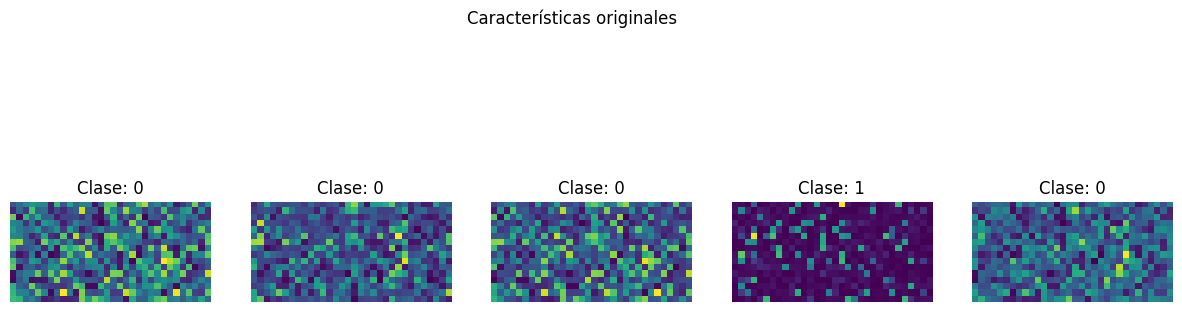

In [ ]:
import matplotlib.pyplot as plt

# Seleccionar un lote de características originales del conjunto de entrenamiento
original_features, original_labels = next(iter(train_loader))

# Visualizar las primeras características originales
num_samples = min(5, original_features.size(0))  # Número de muestras a visualizar
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    feature_vector = original_features[i].cpu().numpy().reshape(16, 32)  # Cambiar la forma para visualizar
    axes[i].imshow(feature_vector, cmap='viridis')
    axes[i].set_title(f"Clase: {original_labels[i].item()}")
    axes[i].axis('off')

plt.suptitle("Características originales")
plt.show()


In [ ]:
# prompt: add a code where the execution og google colab stop, and the rest of cells are not executed

# import os
# os.kill(os.getpid(), 9)


In [ ]:
# # prompt: consider previous code. How retain the model with least loss?. The generate samples of such best model

# # Load the best model state
# model.load_state_dict(best_model_state)

# # Generate samples using the best model
# sampled_images = diffusion.sample(batch_size=4)
# print(sampled_images.shape)  # (4, 3, 16, 16)


In [ ]:
# # prompt: quiero pasar sampled_seq a numpy matrix, ademas quiero imprimir primer elemtno

# sampled_seq_np = sampled_images.numpy()
# print("Shape of the sampled sequence as a NumPy array:", sampled_seq_np.shape)

# # Calculate mean and standard deviation
# mean_value = np.mean(sampled_seq_np)
# std_value = np.std(sampled_seq_np)

# print("Mean value in the matrix:", mean_value)
# print("Standard deviation in the matrix:", std_value)

In [ ]:
# import matplotlib.pyplot as plt

# # Extract the first image from the sampled_images tensor
# first_image = sampled_images[0]

# # Convert the image to a NumPy array and transpose it to (height, width, channels)
# image_array = first_image.cpu().numpy().transpose(1, 2, 0)

# # Display the image using matplotlib
# plt.imshow(image_array)
# plt.show()

In [ ]:
# import torch
# from denoising_diffusion_pytorch import Unet, GaussianDiffusion

# model = Unet(
#     dim = 64,
#     dim_mults = (1, 2, 4, 8),
#     flash_attn = True
# )

# diffusion = GaussianDiffusion(
#     model,
#     image_size = 16,
#     timesteps = 100    # number of steps
# )

# # #training_images = torch.rand(1000, 3, 16, 16) # images are normalized from 0 to 1
# training_images = torch.from_numpy(train_features_numpy)
# loss = diffusion(training_images)
# loss.backward()


# # # after a lot of training

# # sampled_images = diffusion.sample(batch_size = 4)
# # sampled_images.shape # (4, 3, 128, 128)

In [ ]:
# losses = []

# training_images = torch.rand(500, 3, 16, 16)


# #training_images = torch.from_numpy(train_features_numpy)

# for i in range(10):
#     # training_images = torch.rand(1000, 3, 16, 16) # images are normalized from 0 to 1
#     #loss.backward(retain_graph=True)
#     loss = diffusion(training_images)
#     loss.backward()
#     losses.append(loss.item())
#     print(f"Iteration {i}: Loss = {loss.item():.4f}")
#     #if i % 100 == 0:
#     #    print(f"Iteration {i}: Loss = {loss.item():.4f}")

In [ ]:
# print(loss.item())

In [ ]:
# # prompt: given this code "#training_images = torch.rand(1000, 3, 16, 16) # images are normalized from 0 to 1
# # training_images = torch.from_numpy(train_features_numpy)
# # loss = diffusion(training_images)
# # loss.backward()". I suppose that it refers to one iteration. How can consider 1000 iterations where I can see the loss evolution?

# losses = []
# for i in range(1000):
#     # training_images = torch.rand(1000, 3, 16, 16) # images are normalized from 0 to 1
#     training_images = torch.from_numpy(train_features_numpy)
#     loss = diffusion(training_images)
#     loss.backward()
#     losses.append(loss.item())
#     if i % 100 == 0:
#         print(f"Iteration {i}: Loss = {loss.item():.4f}")

# # Plot the loss evolution
# import matplotlib.pyplot as plt
# plt.plot(losses)
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.show()


In [ ]:
# print(loss)

In [ ]:
sampled_images_0[3]

tensor([[[-0.6396, -0.7222, -0.7692, -0.8758, -0.6948, -0.9349, -0.8845,
          -0.8016, -0.7769, -0.7647, -0.8620, -0.9272, -0.9023, -0.8437,
          -0.7486, -0.4376],
         [-0.7705, -0.6022, -0.8192, -0.7567, -0.6065, -0.5376, -0.6370,
          -0.8902, -0.8853, -0.8523, -0.9119, -0.9539, -0.8957, -0.6514,
          -0.8309, -0.8139],
         [-0.8418, -0.7205, -0.9075, -0.7625, -0.7563, -0.7252, -0.8988,
          -0.8760, -0.7944, -0.9571, -0.8599, -0.5884, -0.8379, -0.8916,
          -0.6705, -0.9263],
         [-0.2147, -0.7923, -0.7884, -0.8844, -1.0000, -0.8160, -0.8659,
          -0.9339, -0.6592, -0.8545, -0.8002, -0.8551, -0.8645, -0.7403,
          -0.7770, -0.9572],
         [-0.6128, -1.0000, -0.5660, -0.7820, -0.5603, -0.7254, -0.5790,
          -0.9044, -0.8055, -0.7635, -0.8126, -0.9214, -0.8594, -0.8597,
          -0.9276, -0.7756],
         [-0.9691, -0.5774, -0.8421, -0.8186, -0.7566, -0.8668, -0.9043,
          -0.9558, -0.9766, -0.7886, -0.8239, -0.855

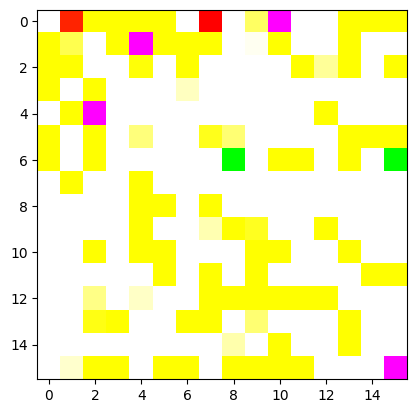

In [ ]:
# prompt: how print image given in the forst image from sampled_images

import matplotlib.pyplot as plt

# Extract the first image from the sampled_images tensor
first_image = 255*((sampled_images_0[1]-min_value_0)/(max_value_0 - min_value_0))

# Convert the image to a NumPy array and transpose it to (height, width, channels)
image_array = first_image.cpu().numpy().transpose(1, 2, 0)

# Display the image using matplotlib
plt.imshow(image_array)
plt.show()


In [ ]:
#HECHO # Correr unas 5 veces y confirmar porcentaje alto (100+, 50 aleatorio, 1 resultados pobres)

# HECHO #> Leer unos cuantos papers más
# HECHO #> Elegir un enfoque para implementar, idealmente sencillo, que trabaje con los features

#1- Calcular cuánto demora la inferencia de la difusión
#2- Buscar sets de datos 3-5 con máximo 20 clases, medicina (dermatología, que sean desbalanceadas)
#3- Más testeos (+ de 100 épocas)

#Google Scholar
# Cargar el set de datos y utilizarlo en vez de las flores, confirmar mismos resultados
#4- Buscar técnica de data augmentation

In [ ]:
# Invertir Train/Test
# Dividir clase con menos datos x1, x0.5, x0.25
# Buscar set de datos desbalanceado y probar
# Algoritmo

In [ ]:
# Resultado sin difusión sobre test (extraer features y ver precisión sobre test) y sin aumentación
# Lo mismo con aumentación GAUSSIANA, 3 veces cada uno
# LO MISMO CON AUMENTACIÓN CON DIFUSIÓN, 3 VECES

#Ver sobre train y test (importante test)

#AGREGAR ACCURACY, PRECISIÓN, RECALL, FSCORE Y MATRIZ DE CONFUSIÓN

#IMAGENES PIXELEADAS

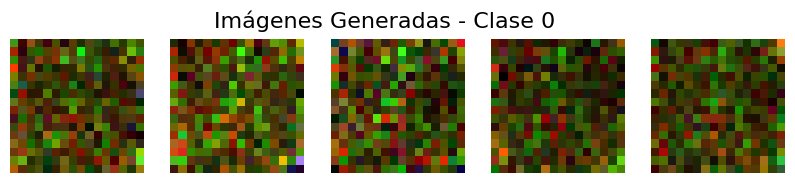

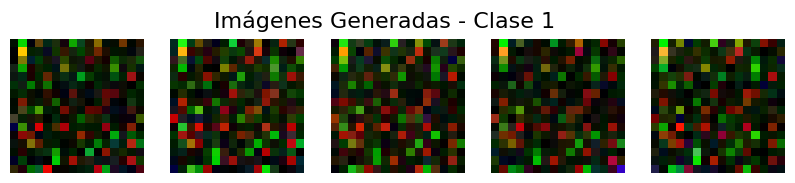

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Función para mostrar imágenes generadas con normalización correcta
def mostrar_imagenes_generadas(sampled_images, num_images=5, title="Imágenes Generadas"):
    num_images = min(num_images, sampled_images.shape[0])  # Asegurar que no excedemos el tamaño del lote
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    fig.suptitle(title, fontsize=16)

    for i in range(num_images):
        img = sampled_images[i].cpu().numpy().transpose(1, 2, 0)  # Reorganizar los ejes para visualización

        # Normalizar a rango [0, 255]
        img = 255 * (img - img.min()) / (img.max() - img.min() + 1e-8)
        img = img.clip(0, 255).astype(np.uint8)  # Asegurar valores válidos y convertir a uint8

        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

# Mostrar imágenes generadas para la clase 0
mostrar_imagenes_generadas(sampled_images_0, num_images=5, title="Imágenes Generadas - Clase 0")

# Mostrar imágenes generadas para la clase 1
mostrar_imagenes_generadas(sampled_images_1, num_images=5, title="Imágenes Generadas - Clase 1")


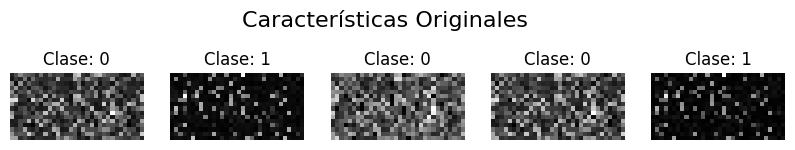

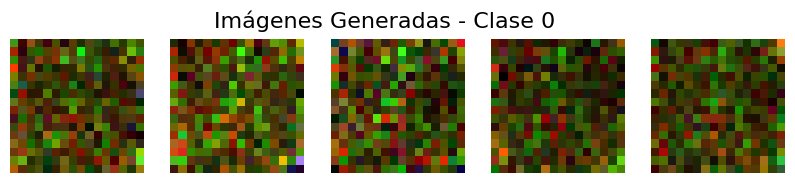

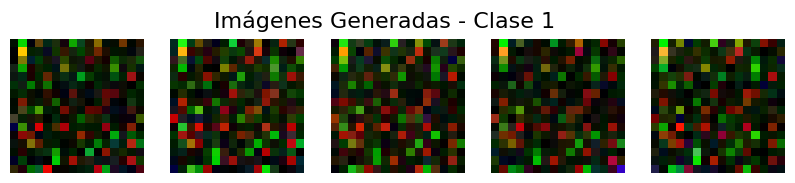

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Función para visualizar características originales con normalización correcta
def mostrar_features_originales(features, labels, num_images=5, title="Características Originales"):
    num_images = min(num_images, features.shape[0])  # Asegurar que no excedemos el tamaño del lote
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    fig.suptitle(title, fontsize=16)

    for i in range(num_images):
        img = features[i].cpu().numpy().reshape(16, 32)  # Reorganizar la forma para visualizar

        # Normalizar a rango [0, 255]
        img = 255 * (img - img.min()) / (img.max() - img.min() + 1e-8)
        img = img.clip(0, 255).astype(np.uint8)

        axes[i].imshow(img, cmap='gray')  # Mostrar en escala de grises
        axes[i].set_title(f"Clase: {labels[i].item()}")
        axes[i].axis('off')

    plt.show()

# Función para visualizar imágenes generadas
def mostrar_imagenes_generadas(sampled_images, num_images=5, title="Imágenes Generadas"):
    num_images = min(num_images, sampled_images.shape[0])  # Asegurar que no excedemos el tamaño del lote
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    fig.suptitle(title, fontsize=16)

    for i in range(num_images):
        img = sampled_images[i].cpu().numpy().transpose(1, 2, 0)  # Reorganizar los ejes para visualización

        # Normalizar a rango [0, 255]
        img = 255 * (img - img.min()) / (img.max() - img.min() + 1e-8)
        img = img.clip(0, 255).astype(np.uint8)

        axes[i].imshow(img)  # Mostrar en colores normales
        axes[i].axis('off')

    plt.show()

# Mostrar características originales con normalización
original_features, original_labels = next(iter(train_loader))
mostrar_features_originales(original_features, original_labels, num_images=5, title="Características Originales")

# Mostrar imágenes generadas para la clase 0 y 1
mostrar_imagenes_generadas(sampled_images_0, num_images=5, title="Imágenes Generadas - Clase 0")
mostrar_imagenes_generadas(sampled_images_1, num_images=5, title="Imágenes Generadas - Clase 1")


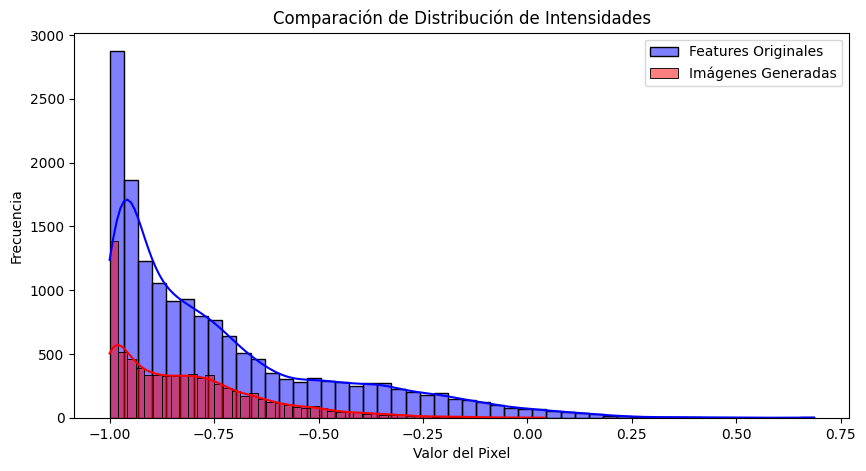

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extraer los valores de pixel de las features originales y las generadas
original_pixels = original_features.numpy().flatten()  # Aplanar a 1D
generated_pixels = sampled_images_0.numpy().flatten()  # Aplanar a 1D

# Graficar histogramas de la distribución de intensidades
plt.figure(figsize=(10, 5))
sns.histplot(original_pixels, bins=50, color='blue', label="Features Originales", kde=True)
sns.histplot(generated_pixels, bins=50, color='red', label="Imágenes Generadas", kde=True)

plt.legend()
plt.title("Comparación de Distribución de Intensidades")
plt.xlabel("Valor del Pixel")
plt.ylabel("Frecuencia")
plt.show()


#AUMENTO

In [ ]:
# Convierte los datos y etiquetas a tensores para contar las etiquetas
train_labels_tensor = torch.tensor(train_dataset.labels).clone().detach()

# Cuenta las etiquetas de cada clase
class_counts = torch.bincount(train_labels_tensor)
minority_class = torch.argmin(class_counts).item()
majority_class_count = class_counts.max().item()

# Determina cuántas muestras faltan para balancear la clase menos poblada
num_samples_needed = majority_class_count - class_counts[minority_class].item()

# Usa el DataLoader de aumento creado previamente para la clase minoritaria (augmented_loader_0 o augmented_loader_1)
augmented_loader = augmented_loader_0 if minority_class == 0 else augmented_loader_1

# Recoge las features necesarias para balancear
augmented_features = []
augmented_labels = []
total_samples_collected = 0

# Repite la recolección de datos de aumento hasta que se completen las muestras necesarias
while total_samples_collected < num_samples_needed:
    for features, labels in augmented_loader:
        if total_samples_collected >= num_samples_needed:
            break
        # Selecciona el número necesario de muestras para balancear
        samples_to_add = min(features.size(0), num_samples_needed - total_samples_collected)
        augmented_features.append(features[:samples_to_add])
        augmented_labels.append(labels[:samples_to_add])
        total_samples_collected += samples_to_add

# Convierte los features y etiquetas originales de `train_data` a tensores si aún no lo están
train_features_tensor = torch.tensor(train_data).float()
train_labels_tensor = torch.tensor(train_labels).long()

# Concatena las listas de aumento y convierte a tensores
augmented_features = torch.cat(augmented_features)
augmented_labels = torch.cat(augmented_labels)

# Combina los features y etiquetas originales con las de aumento
train_features_balanced = torch.cat([train_features_tensor, augmented_features])
train_labels_balanced = torch.cat([train_labels_tensor, augmented_labels])

# Crea un nuevo DataLoader balanceado
balanced_dataset = CustomDataset(train_features_balanced.numpy(), train_labels_balanced.numpy())
balanced_loader = DataLoader(balanced_dataset, batch_size=32, shuffle=True)

print("Conjunto balanceado creado.")


Conjunto balanceado creado.


<ipython-input-358-ab3e258cb699>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(train_dataset.labels).clone().detach()


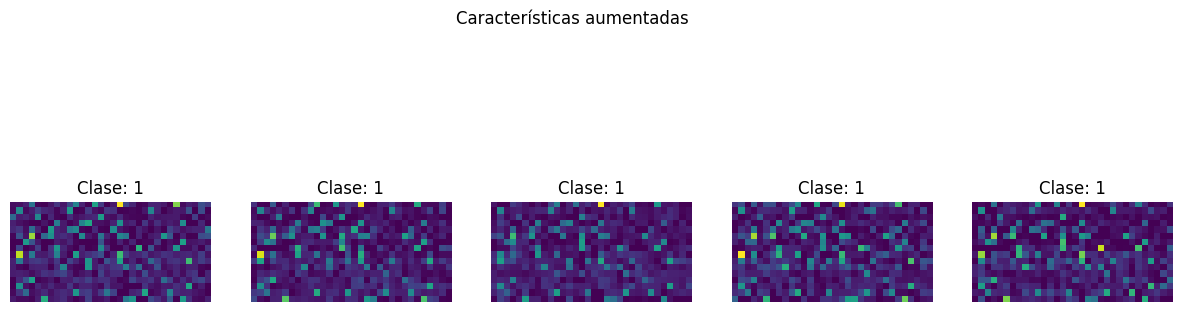

In [ ]:
# Seleccionar un lote de características generadas (aumentadas) del conjunto de aumento
augmented_features, augmented_labels = next(iter(augmented_loader_0 if minority_class == 0 else augmented_loader_1))

# Visualizar las primeras características generadas
num_samples = min(5, augmented_features.size(0))  # Número de muestras a visualizar
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    feature_vector = augmented_features[i].cpu().numpy().reshape(16, 32)  # Cambiar la forma para visualizar
    axes[i].imshow(feature_vector, cmap='viridis')
    axes[i].set_title(f"Clase: {augmented_labels[i].item()}")
    axes[i].axis('off')

plt.suptitle("Características aumentadas")
plt.show()


In [ ]:
# Función para agregar ruido gaussiano a las features
def add_gaussian_noise(features, mean=0.0, std=0.1):
    noise = torch.normal(mean=mean, std=std, size=features.shape)
    return features + noise

# Identifica las clases minoritaria y mayoritaria en el dataset de entrenamiento
class_counts = torch.bincount(train_labels_tensor)
minority_class = torch.argmin(class_counts).item()  # Índice de la clase menos poblada
majority_class_count = class_counts.max().item()    # Cantidad de elementos en la clase más poblada

# Augmentación solo para la clase minoritaria para balancear las clases
augmented_train_features = []
augmented_train_labels = []

# Filtrar el conjunto de entrenamiento para obtener solo los elementos de la clase minoritaria
minority_class_indices = (train_labels_tensor == minority_class).nonzero(as_tuple=True)[0]
minority_class_features = train_features_tensor[minority_class_indices]

# Generar augmentaciones para la clase minoritaria hasta alcanzar el tamaño de la clase mayoritaria
while len(augmented_train_features) + len(minority_class_features) < majority_class_count:
    for features in minority_class_features:
        augmented_features = add_gaussian_noise(features)  # Agregar ruido gaussiano
        augmented_train_features.append(augmented_features)
        augmented_train_labels.append(minority_class)
        if len(augmented_train_features) + len(minority_class_features) >= majority_class_count:
            break

# Convierte las listas de augmentaciones en tensores
augmented_train_features = torch.stack(augmented_train_features)
augmented_train_labels = torch.tensor(augmented_train_labels)

# Combina los datos originales con los aumentados en un solo conjunto de entrenamiento
train_features_combined = torch.cat((train_features_tensor, augmented_train_features))
train_labels_combined = torch.cat((train_labels_tensor, augmented_train_labels))

# Crear el TensorDataset combinado para entrenamiento
train_features_dataset = TensorDataset(train_features_combined, train_labels_combined)

# Imprime el tamaño del nuevo conjunto de entrenamiento balanceado
print("Nuevo tamaño de train_features_dataset:", len(train_features_dataset))
# Crear un DataLoader para el conjunto balanceado con ruido gaussiano
train_features_gaussian_loader = DataLoader(train_features_dataset, batch_size=32, shuffle=True)

print("DataLoader para conjunto balanceado con ruido gaussiano creado.")



Nuevo tamaño de train_features_dataset: 808
DataLoader para conjunto balanceado con ruido gaussiano creado.


#REPLICACIÓN Y DV 0

In [ ]:
# Aumentación por replicación
def augment_by_replication(features, labels, target_class, num_samples_needed):
    # Seleccionar las características de la clase objetivo (minoritaria)
    target_class_indices = (labels == target_class).nonzero(as_tuple=True)[0]
    target_class_features = features[target_class_indices]

    # Replicar las características de la clase objetivo
    replicated_features = target_class_features.repeat((num_samples_needed // target_class_features.size(0)) + 1, 1)

    # Cortar las muestras adicionales para igualar exactamente el número necesario
    replicated_features = replicated_features[:num_samples_needed]
    replicated_labels = torch.full((num_samples_needed,), target_class, dtype=torch.long)

    return replicated_features, replicated_labels

# Realizar la replicación para balancear las clases
minority_class_indices = (train_labels_tensor == minority_class).nonzero(as_tuple=True)[0]
num_samples_needed = majority_class_count - class_counts[minority_class].item()

replicated_features, replicated_labels = augment_by_replication(train_features_tensor, train_labels_tensor, minority_class, num_samples_needed)

# Crear un nuevo conjunto balanceado con las muestras replicadas
replicated_features_balanced = torch.cat([train_features_tensor, replicated_features])
replicated_labels_balanced = torch.cat([train_labels_tensor, replicated_labels])

# Crear un DataLoader con el conjunto replicado
replicated_dataset = CustomDataset(replicated_features_balanced.numpy(), replicated_labels_balanced.numpy())
replicated_loader = DataLoader(replicated_dataset, batch_size=32, shuffle=True)

print("Conjunto balanceado con replicación creado.")


Conjunto balanceado con replicación creado.


In [ ]:
# Aumentación con ruido gaussiano escalado
def augment_with_scaled_gaussian(features, labels, target_class, num_samples_needed, std_scale=0.01):
    # Seleccionar las características de la clase objetivo (minoritaria)
    target_class_indices = (labels == target_class).nonzero(as_tuple=True)[0]
    target_class_features = features[target_class_indices]

    # Generar ruido gaussiano con desviación estándar pequeña
    noise = torch.normal(0, std_scale, size=(num_samples_needed, target_class_features.size(1)))

    # Aplicar el ruido gaussiano a las características replicadas
    noisy_features = target_class_features.repeat((num_samples_needed // target_class_features.size(0)) + 1, 1)[:num_samples_needed] + noise
    noisy_labels = torch.full((num_samples_needed,), target_class, dtype=torch.long)

    return noisy_features, noisy_labels

# Realizar la aumentación con ruido gaussiano escalado para balancear las clases
scaled_gaussian_features, scaled_gaussian_labels = augment_with_scaled_gaussian(
    train_features_tensor, train_labels_tensor, minority_class, num_samples_needed, std_scale=0.01
)

# Crear un nuevo conjunto balanceado con las muestras aumentadas
scaled_features_balanced = torch.cat([train_features_tensor, scaled_gaussian_features])
scaled_labels_balanced = torch.cat([train_labels_tensor, scaled_gaussian_labels])

# Crear un DataLoader con el conjunto balanceado por ruido gaussiano escalado
scaled_dataset = CustomDataset(scaled_features_balanced.numpy(), scaled_labels_balanced.numpy())
scaled_loader = DataLoader(scaled_dataset, batch_size=32, shuffle=True)

print("Conjunto balanceado con ruido gaussiano escalado creado.")


Conjunto balanceado con ruido gaussiano escalado creado.


#STATS

##1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch.nn as nn
import torch.optim as optim

# Define una función para entrenar el modelo con registro de pérdida
def train_model_with_loss_logging(train_loader, model, criterion, optimizer, num_epochs=30):
    for epoch in range(num_epochs):
        model.train()  # Poner el modelo en modo de entrenamiento
        epoch_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)  # Pérdida promedio por época
        print(f"Época {epoch+1}/{num_epochs}, Pérdida Promedio: {avg_loss:.4f}")
    print(f"Entrenamiento completado en {num_epochs} épocas.")

# Define una función para evaluar el modelo con métricas
def evaluate_model(loader, loader_name, model):
    all_targets = []
    all_predictions = []

    model.eval()  # Poner el modelo en modo de evaluación
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_targets, all_predictions)

    print(f"\nEvaluación en {loader_name}:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)

# Paso 1: Entrenamiento y Evaluación con el Conjunto Original
model_original = Net(input_size=train_features_tensor.size(1))
criterion = nn.CrossEntropyLoss()
optimizer_original = optim.Adam(model_original.parameters(), lr=0.001)

print("\nEntrenamiento con el conjunto original:")
train_model_with_loss_logging(train_loader, model_original, criterion, optimizer_original)
evaluate_model(test_loader, "Conjunto de prueba original - Modelo entrenado en conjunto original", model_original)

# Paso 2: Entrenamiento y Evaluación con el Conjunto Balanceado con Aumentación de Difusión
model_diffusion = Net(input_size=train_features_tensor.size(1))
optimizer_diffusion = optim.Adam(model_diffusion.parameters(), lr=0.001)

print("\nEntrenamiento con el conjunto balanceado con datos de difusión:")
train_model_with_loss_logging(balanced_loader, model_diffusion, criterion, optimizer_diffusion)
evaluate_model(test_loader, "Conjunto de prueba original - Modelo entrenado en conjunto balanceado con datos de difusión", model_diffusion)

# Paso 3: Entrenamiento y Evaluación con el Conjunto Balanceado por Replicación
model_replica = Net(input_size=train_features_tensor.size(1))
optimizer_replica = optim.Adam(model_replica.parameters(), lr=0.001)

print("\nEntrenamiento con el conjunto balanceado por replicación:")
train_model_with_loss_logging(replicated_loader, model_replica, criterion, optimizer_replica)
evaluate_model(test_loader, "Conjunto de prueba original - Modelo entrenado en conjunto balanceado por replicación", model_replica)

# Paso 4: Entrenamiento y Evaluación con el Conjunto Balanceado con Ruido Gaussiano Escalado
model_scaled = Net(input_size=train_features_tensor.size(1))
optimizer_scaled = optim.Adam(model_scaled.parameters(), lr=0.001)

print("\nEntrenamiento con el conjunto balanceado con ruido gaussiano escalado:")
train_model_with_loss_logging(scaled_loader, model_scaled, criterion, optimizer_scaled)
evaluate_model(test_loader, "Conjunto de prueba original - Modelo entrenado en conjunto balanceado con ruido gaussiano escalado", model_scaled)

# Paso 5: Entrenamiento y Evaluación con el Conjunto Balanceado con Ruido Gaussiano
model_gaussian = Net(input_size=train_features_tensor.size(1))
optimizer_gaussian = optim.Adam(model_gaussian.parameters(), lr=0.001)

print("\nEntrenamiento con el conjunto balanceado con ruido gaussiano:")
train_model_with_loss_logging(train_features_gaussian_loader, model_gaussian, criterion, optimizer_gaussian)
evaluate_model(test_loader, "Conjunto de prueba original - Modelo entrenado en conjunto balanceado con ruido gaussiano", model_gaussian)

# Imprime tamaños de los conjuntos de datos incluyendo el modelo de ruido gaussiano
print("\nTamaños de los conjuntos de entrenamiento:")
print("Conjunto de entrenamiento original:", len(train_dataset))
print("Conjunto balanceado (original + aumentación de difusión):", len(balanced_dataset))
print("Conjunto balanceado por replicación:", len(replicated_dataset))
print("Conjunto balanceado con ruido gaussiano escalado:", len(scaled_dataset))
print("Conjunto balanceado con ruido gaussiano:", len(train_features_dataset))  # Tamaño del conjunto con ruido gaussiano




Entrenamiento con el conjunto original:
Época 1/30, Pérdida Promedio: 0.4231
Época 2/30, Pérdida Promedio: 0.1128
Época 3/30, Pérdida Promedio: 0.0359
Época 4/30, Pérdida Promedio: 0.0193
Época 5/30, Pérdida Promedio: 0.0134
Época 6/30, Pérdida Promedio: 0.0094
Época 7/30, Pérdida Promedio: 0.0071
Época 8/30, Pérdida Promedio: 0.0057
Época 9/30, Pérdida Promedio: 0.0048
Época 10/30, Pérdida Promedio: 0.0042
Época 11/30, Pérdida Promedio: 0.0034
Época 12/30, Pérdida Promedio: 0.0033
Época 13/30, Pérdida Promedio: 0.0026
Época 14/30, Pérdida Promedio: 0.0024
Época 15/30, Pérdida Promedio: 0.0021
Época 16/30, Pérdida Promedio: 0.0019
Época 17/30, Pérdida Promedio: 0.0017
Época 18/30, Pérdida Promedio: 0.0016
Época 19/30, Pérdida Promedio: 0.0015
Época 20/30, Pérdida Promedio: 0.0014
Época 21/30, Pérdida Promedio: 0.0013
Época 22/30, Pérdida Promedio: 0.0012
Época 23/30, Pérdida Promedio: 0.0011
Época 24/30, Pérdida Promedio: 0.0010
Época 25/30, Pérdida Promedio: 0.0009
Época 26/30, Pérdi

##2

In [ ]:
from sklearn.metrics import classification_report

# Función para imprimir la cantidad de muestras en cada clase de un Dataset
def print_class_counts(dataset, dataset_name):
    labels = [label.item() for _, label in dataset]
    class_counts = {0: labels.count(0), 1: labels.count(1)}
    print(f"\nCantidad de muestras en {dataset_name}:")
    print(f"Clase 0: {class_counts[0]} muestras")
    print(f"Clase 1: {class_counts[1]} muestras")

# Imprimir cantidad de muestras en cada clase para cada conjunto
print_class_counts(train_dataset, "Conjunto de entrenamiento original")
print_class_counts(balanced_dataset, "Conjunto balanceado con datos de difusión")
print_class_counts(replicated_dataset, "Conjunto balanceado por replicación")
print_class_counts(scaled_dataset, "Conjunto balanceado con ruido gaussiano escalado")
print_class_counts(train_features_dataset, "Conjunto balanceado con ruido gaussiano simple")

# Función para evaluar el modelo y generar el informe de clasificación
def evaluate_and_report(loader, model, loader_name):
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Generar y mostrar el classification_report
    report = classification_report(all_targets, all_predictions, target_names=["Clase 0", "Clase 1"])
    print(f"\nClassification Report for {loader_name}:")
    print(report)

# Evaluar cada modelo y generar informes
evaluate_and_report(test_loader, model_original, "Conjunto original - Modelo entrenado en conjunto original")
evaluate_and_report(test_loader, model_diffusion, "Conjunto original - Modelo entrenado en conjunto balanceado con datos de difusión")
evaluate_and_report(test_loader, model_replica, "Conjunto original - Modelo entrenado en conjunto balanceado por replicación")
evaluate_and_report(test_loader, model_scaled, "Conjunto original - Modelo entrenado en conjunto balanceado con ruido gaussiano escalado")
evaluate_and_report(test_loader, model_gaussian, "Conjunto original - Modelo entrenado en conjunto balanceado con ruido gaussiano simple")


Cantidad de muestras en Conjunto de entrenamiento original:
Clase 0: 404 muestras
Clase 1: 396 muestras

Cantidad de muestras en Conjunto balanceado con datos de difusión:
Clase 0: 404 muestras
Clase 1: 404 muestras

Cantidad de muestras en Conjunto balanceado por replicación:
Clase 0: 404 muestras
Clase 1: 404 muestras

Cantidad de muestras en Conjunto balanceado con ruido gaussiano escalado:
Clase 0: 404 muestras
Clase 1: 404 muestras

Cantidad de muestras en Conjunto balanceado con ruido gaussiano simple:
Clase 0: 404 muestras
Clase 1: 404 muestras

Classification Report for Conjunto original - Modelo entrenado en conjunto original:
              precision    recall  f1-score   support

     Clase 0       0.83      0.91      0.87      5000
     Clase 1       0.89      0.80      0.84      4605

    accuracy                           0.85      9605
   macro avg       0.86      0.85      0.85      9605
weighted avg       0.86      0.85      0.85      9605


Classification Report for C

In [ ]:
import os
import matplotlib.pyplot as plt

# Función para preparar las imágenes de cada método con etiquetas corregidas
def preparar_imagenes(loader, num_samples=5):
    features, labels = next(iter(loader))
    # Ahora: 0 es No-Cáncer (Benigna), 1 es Cáncer (Maligna)
    class_0_images = [features[i].cpu().numpy().reshape(16, 32) for i in range(len(labels)) if labels[i].item() == 1][:num_samples]
    class_1_images = [features[i].cpu().numpy().reshape(16, 32) for i in range(len(labels)) if labels[i].item() == 0][:num_samples]
    return class_0_images, class_1_images

# Crear una carpeta para guardar las imágenes si no existe
output_dir = "imagenes_metodos"
os.makedirs(output_dir, exist_ok=True)

# Obtener imágenes de cada método
original_class_0, original_class_1 = preparar_imagenes(train_loader)
diffusion_class_0, diffusion_class_1 = preparar_imagenes(balanced_loader)
replication_class_0, replication_class_1 = preparar_imagenes(replicated_loader)
gaussian_class_0, gaussian_class_1 = preparar_imagenes(train_features_gaussian_loader)
scaled_class_0, scaled_class_1 = preparar_imagenes(scaled_loader)

# Preparar la figura para cada método
methods = [
    ("Original", original_class_0, original_class_1),
    ("Difusión", diffusion_class_0, diffusion_class_1),
    ("Replicación", replication_class_0, replication_class_1),
    ("Ruido Gaussiano", gaussian_class_0, gaussian_class_1),
    ("Ruido Gaussiano Escalado", scaled_class_0, scaled_class_1)
]

for method_name, class_0_images, class_1_images in methods:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f"Método: {method_name}", fontsize=16)

    # Mostrar las imágenes de la clase No-Cáncer (Benigna) arriba
    for i in range(5):
        axes[0, i].imshow(class_0_images[i], cmap='viridis')
        axes[0, i].set_title(f"Cáncer (Maligna)", fontsize=10)
        axes[0, i].axis('off')

    # Mostrar las imágenes de la clase Cáncer (Maligna) abajo
    for i in range(5):
        axes[1, i].imshow(class_1_images[i], cmap='viridis')
        axes[1, i].set_title(f"No-Cáncer (Benigna)", fontsize=10)
        axes[1, i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Guardar la figura en la carpeta
    output_path = os.path.join(output_dir, f"{method_name.replace(' ', '_')}.png")
    plt.savefig(output_path)
    plt.close(fig)

print(f"Las imágenes han sido guardadas en la carpeta: {output_dir}")


Las imágenes han sido guardadas en la carpeta: imagenes_metodos


##3

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Función para evaluar el modelo, generar métricas e informes, y devolver los resultados como un diccionario
def evaluate_and_export(loader, model, loader_name):
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calcular métricas
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_targets, all_predictions)
    report = classification_report(all_targets, all_predictions, target_names=["Clase 0", "Clase 1"], output_dict=True)

    # Imprimir métricas principales
    print(f"\nEvaluación en {loader_name}:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return {
        "Dataset": loader_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": conf_matrix.tolist(),  # Convertimos a lista para guardar en Excel
        "Classification Report": report
    }

# Evaluar cada modelo y recolectar resultados
results = []

results.append(evaluate_and_export(test_loader, model_original, "Original - Modelo Original"))
results.append(evaluate_and_export(test_loader, model_diffusion, "Original - Datos de Difusión"))
results.append(evaluate_and_export(test_loader, model_replica, "Original - Replicación"))
results.append(evaluate_and_export(test_loader, model_scaled, "Original - Ruido Escalado"))
results.append(evaluate_and_export(test_loader, model_gaussian, "Original - Ruido Gaussiano"))

# Crear un DataFrame para guardar las métricas generales
metrics_df = pd.DataFrame({
    "Dataset": [r["Dataset"] for r in results],
    "Accuracy": [r["Accuracy"] for r in results],
    "Precision": [r["Precision"] for r in results],
    "Recall": [r["Recall"] for r in results],
    "F1 Score": [r["F1 Score"] for r in results]
})

# Guardar las métricas generales en un archivo Excel
metrics_filename = "metrics_results.xlsx"
metrics_df.to_excel(metrics_filename, index=False)

# Guardar los informes de clasificación y matrices de confusión en hojas separadas
with pd.ExcelWriter(metrics_filename, engine="openpyxl", mode="a") as writer:
    for idx, result in enumerate(results):
        # Nombres únicos y cortos para las hojas
        report_sheet_name = f"Report-{idx+1}"
        confusion_sheet_name = f"Confusion-{idx+1}"

        # Guardar el classification report
        report_df = pd.DataFrame(result["Classification Report"]).transpose()
        report_df.to_excel(writer, sheet_name=report_sheet_name)

        # Guardar la matriz de confusión
        conf_matrix_df = pd.DataFrame(result["Confusion Matrix"], index=["Clase 0", "Clase 1"], columns=["Clase 0", "Clase 1"])
        conf_matrix_df.to_excel(writer, sheet_name=confusion_sheet_name)

print(f"\nResultados guardados en el archivo {metrics_filename}.")



Evaluación en Original - Modelo Original:
Accuracy: 85.38%
Precision: 0.86
Recall: 0.85
F1 Score: 0.85
Confusion Matrix:
[[4540  460]
 [ 944 3661]]

Evaluación en Original - Datos de Difusión:
Accuracy: 85.24%
Precision: 0.85
Recall: 0.85
F1 Score: 0.85
Confusion Matrix:
[[4511  489]
 [ 929 3676]]

Evaluación en Original - Replicación:
Accuracy: 85.27%
Precision: 0.85
Recall: 0.85
F1 Score: 0.85
Confusion Matrix:
[[4480  520]
 [ 895 3710]]

Evaluación en Original - Ruido Escalado:
Accuracy: 85.30%
Precision: 0.86
Recall: 0.85
F1 Score: 0.85
Confusion Matrix:
[[4522  478]
 [ 934 3671]]

Evaluación en Original - Ruido Gaussiano:
Accuracy: 85.20%
Precision: 0.85
Recall: 0.85
F1 Score: 0.85
Confusion Matrix:
[[4524  476]
 [ 946 3659]]

Resultados guardados en el archivo metrics_results.xlsx.


#STATS ORIGINALES

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch.nn as nn
import torch.optim as optim

# Define una función para entrenar el modelo con registro de pérdida
def train_model_with_loss_logging(train_loader, model, criterion, optimizer, num_epochs=30):
    for epoch in range(num_epochs):
        model.train()  # Poner el modelo en modo de entrenamiento
        epoch_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)  # Pérdida promedio por época
        print(f"Época {epoch+1}/{num_epochs}, Pérdida Promedio: {avg_loss:.4f}")
    print(f"Entrenamiento completado en {num_epochs} épocas.")

# Define una función para evaluar el modelo con métricas
def evaluate_model(loader, loader_name, model):
    all_targets = []
    all_predictions = []

    model.eval()  # Poner el modelo en modo de evaluación
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_targets, all_predictions)

    print(f"\nEvaluación en {loader_name}:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)

# Paso 1: Entrenamiento y Evaluación con el Conjunto de Entrenamiento Original
model_original = Net(input_size=train_features_tensor.size(1))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_original.parameters(), lr=0.001)

print("\nEntrenamiento con el conjunto original:")
train_model_with_loss_logging(train_loader, model_original, criterion, optimizer)
evaluate_model(test_loader, "Conjunto de prueba original - Modelo entrenado en conjunto original", model_original)

# Paso 2: Entrenamiento y Evaluación con el Conjunto Balanceado con Aumento de Ruido Gaussiano
train_features_gaussian_loader = DataLoader(train_features_dataset, batch_size=32, shuffle=True)  # Loader para datos con ruido
model_gaussian = Net(input_size=train_features_combined.size(1))
optimizer_gaussian = optim.Adam(model_gaussian.parameters(), lr=0.001)

print("\nEntrenamiento con el conjunto balanceado con ruido gaussiano:")
train_model_with_loss_logging(train_features_gaussian_loader, model_gaussian, criterion, optimizer_gaussian)
evaluate_model(test_loader, "Conjunto de prueba original - Modelo entrenado en conjunto con ruido gaussiano", model_gaussian)

# Paso 3: Entrenamiento y Evaluación con el Conjunto de Entrenamiento Balanceado con Aumentación de Difusión
model_combined = Net(input_size=train_features_tensor.size(1))
optimizer_combined = optim.Adam(model_combined.parameters(), lr=0.001)

print("\nEntrenamiento con el conjunto balanceado con datos de difusión:")
train_model_with_loss_logging(balanced_loader, model_combined, criterion, optimizer_combined)
evaluate_model(test_loader, "Conjunto de prueba original - Modelo entrenado en conjunto balanceado con datos de difusión", model_combined)

# Imprime tamaños de los conjuntos de datos
print("\nTamaños de los conjuntos de entrenamiento:")
print("Conjunto de entrenamiento original:", len(train_dataset))
print("Conjunto balanceado (original + aumentación de difusión):", len(balanced_dataset))
print("Conjunto con ruido gaussiano:", len(train_features_dataset))



Entrenamiento con el conjunto original:
Época 1/30, Pérdida Promedio: 0.2891
Época 2/30, Pérdida Promedio: 0.0396
Época 3/30, Pérdida Promedio: 0.0143
Época 4/30, Pérdida Promedio: 0.0083
Época 5/30, Pérdida Promedio: 0.0060
Época 6/30, Pérdida Promedio: 0.0048
Época 7/30, Pérdida Promedio: 0.0038
Época 8/30, Pérdida Promedio: 0.0030
Época 9/30, Pérdida Promedio: 0.0025
Época 10/30, Pérdida Promedio: 0.0020
Época 11/30, Pérdida Promedio: 0.0017
Época 12/30, Pérdida Promedio: 0.0015
Época 13/30, Pérdida Promedio: 0.0015
Época 14/30, Pérdida Promedio: 0.0012
Época 15/30, Pérdida Promedio: 0.0011
Época 16/30, Pérdida Promedio: 0.0010
Época 17/30, Pérdida Promedio: 0.0011
Época 18/30, Pérdida Promedio: 0.0008
Época 19/30, Pérdida Promedio: 0.0008
Época 20/30, Pérdida Promedio: 0.0007
Época 21/30, Pérdida Promedio: 0.0007
Época 22/30, Pérdida Promedio: 0.0007
Época 23/30, Pérdida Promedio: 0.0006
Época 24/30, Pérdida Promedio: 0.0006
Época 25/30, Pérdida Promedio: 0.0005
Época 26/30, Pérdi

In [ ]:
# Función para imprimir la cantidad de muestras en cada clase de un Dataset
def print_class_counts(dataset, dataset_name):
    labels = [label.item() for _, label in dataset]
    class_counts = {0: labels.count(0), 1: labels.count(1)}
    print(f"\nCantidad de muestras en {dataset_name}:")
    print(f"Clase 0: {class_counts[0]} muestras")
    print(f"Clase 1: {class_counts[1]} muestras")

# Imprimir cantidad de muestras en cada clase para cada conjunto
print_class_counts(train_dataset, "Conjunto de entrenamiento original")
print_class_counts(train_features_dataset, "Conjunto de entrenamiento con ruido gaussiano")
print_class_counts(balanced_dataset, "Conjunto de entrenamiento balanceado (datos sintéticos)")

from sklearn.metrics import classification_report

def evaluate_and_report(loader, model, loader_name):
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Generar y mostrar el classification_report
    report = classification_report(all_targets, all_predictions, target_names=["Clase 0", "Clase 1"])
    print(f"\nClassification Report for {loader_name}:")
    print(report)

# Evaluar cada modelo y generar informes
evaluate_and_report(test_loader, model_original, "Conjunto original - Modelo entrenado en conjunto original")
evaluate_and_report(test_loader, model_gaussian, "Conjunto original - Modelo entrenado con ruido gaussiano")
evaluate_and_report(test_loader, model_combined, "Conjunto original - Modelo entrenado en conjunto balanceado con datos de difusión")



Cantidad de muestras en Conjunto de entrenamiento original:
Clase 0: 404 muestras
Clase 1: 396 muestras

Cantidad de muestras en Conjunto de entrenamiento con ruido gaussiano:
Clase 0: 404 muestras
Clase 1: 404 muestras

Cantidad de muestras en Conjunto de entrenamiento balanceado (datos sintéticos):
Clase 0: 404 muestras
Clase 1: 404 muestras

Classification Report for Conjunto original - Modelo entrenado en conjunto original:
              precision    recall  f1-score   support

     Clase 0       0.84      0.89      0.87      5000
     Clase 1       0.87      0.82      0.84      4605

    accuracy                           0.86      9605
   macro avg       0.86      0.85      0.86      9605
weighted avg       0.86      0.86      0.86      9605


Classification Report for Conjunto original - Modelo entrenado con ruido gaussiano:
              precision    recall  f1-score   support

     Clase 0       0.81      0.92      0.86      5000
     Clase 1       0.90      0.77      0.83   

In [ ]:
#NOTAS
# ELEGIR DE VALIDACIÓN SOLO CON ORIGINAL
# NO CAMBIAR EPOCAS FEATURES, ELEGIR CON VALIDACIÓN
# PROBAR AUMENTAR AMBAS CLASES, NO SOLO MINORITARIA